# E-GraphSAGE

In [1]:
from dgl import from_networkx
import sklearn
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import numpy as np
from sklearn.metrics import confusion_matrix

import os
from sklearn.utils import shuffle

from dgl.data.utils import save_graphs

#constante
size_embedding = 152
nb_batch = 5

#Data
nbclasses =  2

# Accuracy --------------------------------------------------------------------
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()
# -----------------------------------------------------------------------------

# ------------------------------------------ Model Architecture -----------------------------------------------------------------

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        x = th.cat([edges.src['h'], edges.data['h']], 2)
        y = self.W_msg(x)
        return {'m': y}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Line 4 of algorithm 1 : update all because we are using a full neighborhood sampling and not a k-hop neigh sampling
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Line 5 of algorithm 1
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, size_embedding, activation))
        self.layers.append(SAGELayer(size_embedding, edim, size_embedding, activation)) ##
        self.layers.append(SAGELayer(size_embedding, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
            # Save edge_embeddings
            # nf = 'edge_embeddings'+str(i)+'.txt'
            # sourceFile = open(nf, 'w')
            # print(nfeats, file = sourceFile)
        return nfeats.sum(1)
        # Return a list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]
    
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        v = th.cat([h_u, h_v], 1)
        # if(pr == True):
            # sourceFile = open(filename, 'w')
            # if pr:
                # print(v, file = sourceFile)
            # sourceFile.close()
        score = self.W(v)
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            # Update the features of the specified edges by the provided function
            # DGLGraph.apply_edges(func, edges='__ALL__', etype=None, inplace=False)
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, nbclasses)
    def forward(self, g, nfeats, efeats, eweight = None):
        if eweight != None:
            # apply eweight on the graph
            efe = []
            for i, x in enumerate(eweight):
                efe.append(list(th.Tensor.cpu(g.edata['h'][i][0]).detach().numpy() * th.Tensor.cpu(x).detach().numpy()))

            efe = th.FloatTensor(efe).cuda()
            efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
            g.edata['h'] = efe = efe

        h = self.gnn(g, nfeats, efeats)
        # h = list of node features [[node1_feature1, node1_feature2, ...], [node2_feature1, node2_feature2, ...], ...]
        return self.pred(g, h)

# -------------------------------------------------------------------------------------------------------------------------------

c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Graph + Ablation

In [2]:
# # --------------------------------------------------- MAIN -----------------------------------------------------------

import copy


# Model *******************************************************************************************
# G1.ndata['h'].shape[2] = sizeh = 76 dans ANIDS
# model1 = Model(G1.ndata['h'].shape[2], size_embedding, G1.ndata['h'].shape[2], F.relu, 0.2).cuda()
model1 = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
opt = th.optim.Adam(model1.parameters())

model1_ab = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
opt_ab = th.optim.Adam(model1_ab.parameters())


# Classes
clss = ['BENIGN', 'Brute Force', 'XSS', 'Sql Injection', 'Heartbleed', 'DoS Hulk', 'DDoS', 'PortScan', 'FTP-Patator', 'Bot', 'DoS slowloris', 'DoS GoldenEye', 'DoS Slowhttptest', 'SSH-Patator', 'Infiltration']
# Classes mpping
clss_mpping = {}
cpt = 0
for x in clss:
    clss_mpping[x] = cpt
    cpt += 1
print(clss_mpping)



path, dirs, files = next(os.walk("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/GlobalDataset/Splitted/"))
file_count = len(files)


for nb_files in range(file_count):
    data1 = pd.read_csv(f'{path}{files[nb_files]}', encoding="ISO-8859–1", dtype = str)

    print(f'{files[nb_files]} ++++++++++++++++++++++++++++++++++++++++++++++')
    print("nb total instances in the file : ", len(data1.values))

    print("++++++++++++++++++++++++++++ Train ++++++++++++++++++++++++++++++++")
    
    # Delete two columns (U and V in the excel)
    cols = list(set(list(data1.columns )) - set(list(['Flow Bytes/s',' Flow Packets/s'])) )
    data1 = data1[cols]

    # Mise en forme des noeuds
    data1[' Source IP'] = data1[' Source IP'].apply(str)
    data1[' Source Port'] = data1[' Source Port'].apply(str)
    data1[' Destination IP'] = data1[' Destination IP'].apply(str)
    data1[' Destination Port'] = data1[' Destination Port'].apply(str)
    data1[' Source IP'] = data1[' Source IP'] + ':' + data1[' Source Port']
    data1[' Destination IP'] = data1[' Destination IP'] + ':' + data1[' Destination Port']

    data1.drop(columns=['Flow ID',' Source Port',' Destination Port',' Timestamp'], inplace=True)
    
    data1['DetailedLabel'] = data1[' Label']
    data1['DetailedLabel'] = data1['DetailedLabel'].apply(str)
    # Classes mpping for the DetailedLabel
    data1 = data1.replace({'DetailedLabel': clss_mpping})

    # -------------------- ????????????????????????????????????????? --------------------
    # simply do : nom = list(data1[' Label'].unique())
    nom = []
    nom = nom + [data1[' Label'].unique()[0]]
    for i in range(1, len(data1[' Label'].unique())):
        nom = nom + [data1[' Label'].unique()[i]]
    
    nom.insert(0, nom.pop(nom.index('BENIGN')))

    # Naming the two classes BENIGN {0} / Any Intrusion {1}
    data1[' Label'].replace(nom[0], 0,inplace = True)
    for i in range(1,len(data1[' Label'].unique())):
        data1[' Label'].replace(nom[i], 1,inplace = True)
    
    ##################### LABELS FREQ #######################################
    print()
    print("labels freq after changing labels to binary")
    counts = list(data1[' Label'].value_counts().to_dict().items())
    for j, x in enumerate(counts):
        x = list(x)
        x[1] = x[1] / len(data1)
        counts[j] = x
    print({f'{files[nb_files]}' : counts})
    ##############################################################################

    data1.rename(columns={" Label": "label"},inplace = True)
    label1 = data1.label
    data1.drop(columns=['label'],inplace = True)

    # ******** At this step data1 contains only the data without label column
    # ******** The label column is stored in the label variale 

    # split train and test
    data1 =  pd.concat([data1, label1], axis=1) # ??????? WHY ?
        

    # Split
    X1_train, X1_test, y1_train, y1_test = train_test_split(data1, label1, test_size=0.3, random_state=123, stratify= label1)

    
    # Create mini batches on the Train set
    X1_train = shuffle(X1_train)
    a = b = mean_macro_f1 = 0
    for batch in range(1, nb_batch + 1):
        print(f"+++++++++++++++++ Batch {batch} ++++++++++++++++")
        a = b
        b = int(len(X1_train) / nb_batch) * batch
        if batch == nb_batch :
            b = len(X1_train)
        # The batch :
        X1_train_batched = X1_train.iloc[a:b]
        # y1_train_batched = y1_train.iloc[a:b]
        y1_train_batched = X1_train_batched['label']        
        
        print("nb Train instances : ", len(X1_train_batched.values))

        # for non numerical attributes (categorical data)
        # Since we have a binary classification, the category values willl be replaced with the posterior probability (p(target = Ti | category = Cj))
        # TargetEncoding is also called MeanEncoding, cuz it simply replace each value with (target_i_count_on_category_j) / (total_occurences_of_category_j)
        encoder1 = ce.TargetEncoder(cols=[' Protocol',  'Fwd PSH Flags', ' Fwd URG Flags', ' Bwd PSH Flags', ' Bwd URG Flags'])
        encoder1.fit(X1_train_batched, y1_train_batched)
        X1_train_batched = encoder1.transform(X1_train_batched)

        # scaler (normalization)
        scaler1 = StandardScaler()

        # Manipulate flow content (all columns except : label, Source IP & Destination IP)
        cols_to_norm1 = list(set(list(X1_train_batched.iloc[:, :].columns )) - set(list(['label', ' Source IP', ' Destination IP', 'DetailedLabel'])) )
        X1_train_batched[cols_to_norm1] = scaler1.fit_transform(X1_train_batched[cols_to_norm1])
        
        print("cols_to_norm1 : ", cols_to_norm1)
        print("cols_to_norm1[0] : ", cols_to_norm1[0])
        print("X1_train_batched[cols_to_norm1[0]] : ", X1_train_batched[cols_to_norm1[0]])

        ## Create the h attribute that will contain the content of our flows
        X1_train_batched['h'] = X1_train_batched[ cols_to_norm1 ].values.tolist()
        print("X1_train_batched['h'] : ", X1_train_batched['h'])
        # size of the list containig the content of our flows
        sizeh = len(cols_to_norm1)


        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Before training the data :
        # We need to delete all the attributes (cols_to_norm1) to have the {Source IP, Destination IP, label, h} representation
        X1_train_batched.drop(columns = cols_to_norm1, inplace = True)
        
        # Edge index
        X1_train_batched['Edge_indx'] = list(range(len(X1_train_batched.values)))

        # Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
        columns_titles = [' Source IP', ' Destination IP', 'h', 'label', 'Edge_indx', 'DetailedLabel']
        X1_train_batched = X1_train_batched.reindex(columns=columns_titles)
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        # ------------------------------------------- Creating the Graph Representation -------------------------------------------------------------
        # Create our Multigraph
        G1 = nx.from_pandas_edgelist(X1_train_batched, " Source IP", " Destination IP", ['h','label', 'Edge_indx', 'DetailedLabel'], create_using=nx.MultiDiGraph())
        print("initial nx multigraph G1 : ", G1)

        G1 = from_networkx(G1, edge_attrs=['h','label', 'Edge_indx', 'DetailedLabel'] )
        print("G1.edata['h'] after converting it to a dgl graph : ", len(G1.edata['h']))

        # nodes data // G1.edata['h'].shape[1] : sizeh = number of attributes in a flow
        G1.ndata['h'] = th.ones(G1.num_nodes(), G1.edata['h'].shape[1])
        # edges data // we create a tensor bool array that will represent the train mask
        G1.edata['train_mask'] = th.ones(len(G1.edata['h']), dtype=th.bool)

        # Reshape both tensor lists to a single value in each element for both axis
        G1.ndata['h'] = th.reshape(G1.ndata['h'], (G1.ndata['h'].shape[0], 1, G1.ndata['h'].shape[1]))
        G1.edata['h'] = th.reshape(G1.edata['h'], (G1.edata['h'].shape[0], 1, G1.edata['h'].shape[1]))
        print("G1.edata['h'] after reshape : ", len(G1.edata['h']))
        # ------------------------------------------- --------------------------------- -------------------------------------------------------------

        

        
        # Ablation *************************************************************************
        X1_train_ab = copy.deepcopy(X1_train_batched)

        # print("data IP Addr before changing them : ")
        # print(X1_train_ab[[' Source IP', ' Destination IP']])

        X1_train_ab = X1_train_ab.drop(' Source IP', axis=1)
        X1_train_ab = X1_train_ab.drop(' Destination IP', axis=1)
        
        X1_train_ab[' Source IP'] = list(range(len(X1_train_ab.values)))
        X1_train_ab[' Destination IP'] = list(range(len(X1_train_ab.values), 2 * len(X1_train_ab.values)))

        print()
        # print("data IP Addr after changing them : ")
        # print(X1_train_ab[[' Source IP', ' Destination IP']])
        
        # ------------------------------------------- Creating the Graph Representation -------------------------------------------------------------
        # Create our Ablation Multigraph
        G1_ab = nx.from_pandas_edgelist(X1_train_ab, " Source IP", " Destination IP", ['h','label', 'Edge_indx', 'DetailedLabel'], create_using=nx.MultiDiGraph())
        print("initial nx multigraph G1_ab : ", G1_ab)

        G1_ab = from_networkx(G1_ab, edge_attrs=['h','label', 'Edge_indx', 'DetailedLabel'] )
        print("G1_ab.edata['h'] after converting it to a dgl graph : ", len(G1_ab.edata['h']))

        # nodes data // G1_ab.edata['h'].shape[1] : sizeh = number of attributes in a flow
        G1_ab.ndata['h'] = th.ones(G1_ab.num_nodes(), G1_ab.edata['h'].shape[1])
        # edges data // we create a tensor bool array that will represent the train mask
        G1_ab.edata['train_mask'] = th.ones(len(G1_ab.edata['h']), dtype=th.bool)

        # Reshape both tensor lists to a single value in each element for both axis
        G1_ab.ndata['h'] = th.reshape(G1_ab.ndata['h'], (G1_ab.ndata['h'].shape[0], 1, G1_ab.ndata['h'].shape[1]))
        G1_ab.edata['h'] = th.reshape(G1_ab.edata['h'], (G1_ab.edata['h'].shape[0], 1, G1_ab.edata['h'].shape[1]))
        print("G1_ab.edata['h'] after reshape : ", len(G1_ab.edata['h']))
        # ------------------------------------------- --------------------------------- -------------------------------------------------------------
        
        # ***********************************************************************************
        
        
        # ------------------------------------------- Model -----------------------------------------------------------------------------------------
        ## use of model
        from sklearn.utils import class_weight
        class_weights1 = class_weight.compute_class_weight(class_weight = 'balanced',
                                                        classes = np.unique(G1.edata['label'].cpu().numpy()),
                                                        y = G1.edata['label'].cpu().numpy())
        class_weights1 = th.FloatTensor(class_weights1).cuda()
        criterion1 = nn.CrossEntropyLoss(weight = class_weights1)
        G1 = G1.to('cuda:0')

        node_features1 = G1.ndata['h']
        edge_features1 = G1.edata['h']

        edge_label1 = G1.edata['label']
        train_mask1 = G1.edata['train_mask']


        # to print
        pr = True
        # True if you want to print the embedding vectors
        # the name of the file where the vectors are printed
        filename = './models/M1_weights.txt'
        
        print("\\\\\\\\\\\\\\\\ NORMAL \\\\\\\\\\\\\\\\\\")

        for epoch in range(1, 1000):
            pred = model1(G1, node_features1, edge_features1).cuda()
            loss = criterion1(pred[train_mask1], edge_label1[train_mask1])
            opt.zero_grad()
            loss.backward()
            opt.step()
            if epoch % 100 == 0:
                print('Training acc:', compute_accuracy(pred[train_mask1], edge_label1[train_mask1]), loss)

        pred1 = model1(G1, node_features1, edge_features1).cuda()
        pred1 = pred1.argmax(1)
        pred1 = th.Tensor.cpu(pred1).detach().numpy()
        edge_label1 = th.Tensor.cpu(edge_label1).detach().numpy()

        print('Train metrics :')
        print("Accuracy : ", sklearn.metrics.accuracy_score(edge_label1, pred1))
        print("Precision : ", sklearn.metrics.precision_score(edge_label1, pred1, labels = [0,1]))
        print("Recall : ", sklearn.metrics.recall_score(edge_label1, pred1, labels = [0,1]))
        print("f1_score : ", sklearn.metrics.f1_score(edge_label1, pred1, labels=[0,1]))
        
        

        
        # ------------------------------------------- AB Model -----------------------------------------------------------------------------------------
        ## use of model
        from sklearn.utils import class_weight
        class_weights1_ab = class_weight.compute_class_weight(class_weight = 'balanced',
                                                        classes = np.unique(G1_ab.edata['label'].cpu().numpy()),
                                                        y = G1_ab.edata['label'].cpu().numpy())
        class_weights1_ab = th.FloatTensor(class_weights1_ab).cuda()
        criterion1_ab = nn.CrossEntropyLoss(weight = class_weights1_ab)
        G1_ab = G1_ab.to('cuda:0')

        node_features1_ab = G1_ab.ndata['h']
        edge_features1_ab = G1_ab.edata['h']

        edge_label1_ab = G1_ab.edata['label']
        train_mask1_ab = G1_ab.edata['train_mask']
        
        print("\\\\\\\\\\\\\\\\ ABLATION \\\\\\\\\\\\\\\\\\")
        
        for epoch in range(1, 1000):
            pred_ab = model1_ab(G1_ab, node_features1_ab, edge_features1_ab).cuda()
            loss_ab = criterion1_ab(pred_ab[train_mask1], edge_label1_ab[train_mask1])
            opt_ab.zero_grad()
            loss_ab.backward()
            opt_ab.step()
            if epoch % 100 == 0:
                print('Training acc:', compute_accuracy(pred_ab[train_mask1], edge_label1_ab[train_mask1]), loss_ab)

        pred1_ab = model1_ab(G1_ab, node_features1_ab, edge_features1_ab).cuda()
        pred1_ab = pred1_ab.argmax(1)
        pred1_ab = th.Tensor.cpu(pred1_ab).detach().numpy()
        edge_label1_ab = th.Tensor.cpu(edge_label1_ab).detach().numpy()

        print('Train metrics :')
        print("Accuracy : ", sklearn.metrics.accuracy_score(edge_label1_ab, pred1_ab))
        print("Precision : ", sklearn.metrics.precision_score(edge_label1_ab, pred1_ab, labels = [0,1]))
        print("Recall : ", sklearn.metrics.recall_score(edge_label1_ab, pred1_ab, labels = [0,1]))
        print("f1_score : ", sklearn.metrics.f1_score(edge_label1_ab, pred1_ab, labels=[0,1]))

        



    # ------------------------------------------------ Test ---------------------------------------------------------------------
    print("++++++++++++++++++++++++++++ Test ++++++++++++++++++++++++++++++++")
    print("nb Test instances : ", len(X1_test.values))
    X1_test = encoder1.transform(X1_test)
    X1_test[cols_to_norm1] = scaler1.transform(X1_test[cols_to_norm1])

    # Save X1_test for XAI
    X1_test.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/input/Dataset/XAI/X_test{nb_files}.csv', sep=',', index = False)

    X1_test['h'] = X1_test[ cols_to_norm1 ].values.tolist()

    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Before training the data :
    # We need to delete all the attributes (cols_to_norm1) to have the {Source IP, Destination IP, label, h} representation
    X1_test.drop(columns = cols_to_norm1, inplace = True)
    
    # Edge index
    X1_test['Edge_indx'] = list(range(len(X1_test.values)))

    # Then we need to Swap {label, h} Columns to have the {Source IP, Destination IP, h, label} representation
    columns_titles = [' Source IP', ' Destination IP', 'h', 'label', 'Edge_indx', 'DetailedLabel']
    X1_test = X1_test.reindex(columns=columns_titles)
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    # Graph Construction
    G1_test = nx.from_pandas_edgelist(X1_test, " Source IP", " Destination IP", ['h','label', 'Edge_indx', 'DetailedLabel'],create_using=nx.MultiDiGraph())
    # G1_test = G1_test.to_directed()
    G1_test = from_networkx(G1_test,edge_attrs=['h','label', 'Edge_indx', 'DetailedLabel'] )
    # actual1 = G1_test.edata.pop('label')
    actual1 = G1_test.edata['label']
    G1_test.ndata['feature'] = th.ones(G1_test.num_nodes(), G1.ndata['h'].shape[2])
    G1_test.ndata['feature'] = th.reshape(G1_test.ndata['feature'], (G1_test.ndata['feature'].shape[0], 1, G1_test.ndata['feature'].shape[1]))
    G1_test.edata['h'] = th.reshape(G1_test.edata['h'], (G1_test.edata['h'].shape[0], 1, G1_test.edata['h'].shape[1]))
    G1_test = G1_test.to('cuda:0')
    node_features_test1 = G1_test.ndata['feature']
    edge_features_test1 = G1_test.edata['h']
    
    
    
    # Ablation *************************************************************************
    X1_test_ab = copy.deepcopy(X1_test)

    # print("data IP Addr before changing them : ")
    # print(X1_test_ab[[' Source IP', ' Destination IP']])

    X1_test_ab = X1_test_ab.drop(' Source IP', axis=1)
    X1_test_ab = X1_test_ab.drop(' Destination IP', axis=1)

    X1_test_ab[' Source IP'] = list(range(len(X1_test_ab.values)))
    X1_test_ab[' Destination IP'] = list(range(len(X1_test_ab.values), 2 * len(X1_test_ab.values)))

    print()
    # print("data IP Addr after changing them : ")
    # print(X1_test_ab[[' Source IP', ' Destination IP']])
    
    # Graph Construction
    G1_test_ab = nx.from_pandas_edgelist(X1_test_ab, " Source IP", " Destination IP", ['h','label', 'Edge_indx', 'DetailedLabel'],create_using=nx.MultiDiGraph())
    G1_test_ab = from_networkx(G1_test_ab, edge_attrs=['h','label', 'Edge_indx', 'DetailedLabel'] )
    actual1_ab = G1_test_ab.edata['label']
    G1_test_ab.ndata['feature'] = th.ones(G1_test_ab.num_nodes(), G1_ab.ndata['h'].shape[2])
    G1_test_ab.ndata['feature'] = th.reshape(G1_test_ab.ndata['feature'], (G1_test_ab.ndata['feature'].shape[0], 1, G1_test_ab.ndata['feature'].shape[1]))
    G1_test_ab.edata['h'] = th.reshape(G1_test_ab.edata['h'], (G1_test_ab.edata['h'].shape[0], 1, G1_test_ab.edata['h'].shape[1]))
    G1_test_ab = G1_test_ab.to('cuda:0')
    node_features_test1_ab = G1_test_ab.ndata['feature']
    edge_features_test1_ab = G1_test_ab.edata['h']
    
    # ***********************************************************************************

    print("\\\\\\\\\\\\\\\\ NORMAL \\\\\\\\\\\\\\\\\\")
    print("nb instances : ", len(X1_test.values))

    test_pred1 = model1(G1_test, node_features_test1, edge_features_test1).cuda()
    test_pred1 = test_pred1.argmax(1)
    test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()

    print('Metrics : ')
    print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
    print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
    print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
    print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))
    
    
    print("\\\\\\\\\\\\\\\\ ABLATION \\\\\\\\\\\\\\\\\\")
    print("nb instances : ", len(X1_test_ab.values))

    test_pred1_ab = model1_ab(G1_test_ab, node_features_test1_ab, edge_features_test1_ab).cuda()
    test_pred1_ab = test_pred1_ab.argmax(1)
    test_pred1_ab = th.Tensor.cpu(test_pred1_ab).detach().numpy()

    print('Metrics : ')
    print("Accuracy : ", sklearn.metrics.accuracy_score(actual1_ab, test_pred1_ab))
    print("Precision : ", sklearn.metrics.precision_score(actual1_ab, test_pred1_ab, labels = [0,1]))
    print("Recall : ", sklearn.metrics.recall_score(actual1_ab, test_pred1_ab, labels = [0,1]))
    print("f1_score : ", sklearn.metrics.f1_score(actual1_ab, test_pred1_ab, labels = [0,1]))

    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

{'BENIGN': 0, 'Brute Force': 1, 'XSS': 2, 'Sql Injection': 3, 'Heartbleed': 4, 'DoS Hulk': 5, 'DDoS': 6, 'PortScan': 7, 'FTP-Patator': 8, 'Bot': 9, 'DoS slowloris': 10, 'DoS GoldenEye': 11, 'DoS Slowhttptest': 12, 'SSH-Patator': 13, 'Infiltration': 14}


StopIteration: 

### ACC + F1

In [ ]:
print("\\\\\\\\\\\\\\\\ NORMAL \\\\\\\\\\\\\\\\\\")
print("nb instances : ", len(X1_test.values))

test_pred1 = model1(G1_test, node_features_test1, edge_features_test1).cuda()
test_pred1 = test_pred1.argmax(1)
test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))


print("\\\\\\\\\\\\\\\\ ABLATION \\\\\\\\\\\\\\\\\\")
print("nb instances : ", len(X1_test_ab.values))

test_pred1_ab = model1_ab(G1_test_ab, node_features_test1_ab, edge_features_test1_ab).cuda()
test_pred1_ab = test_pred1_ab.argmax(1)
test_pred1_ab = th.Tensor.cpu(test_pred1_ab).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1_ab, test_pred1_ab))
print("Precision : ", sklearn.metrics.precision_score(actual1_ab, test_pred1_ab, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1_ab, test_pred1_ab, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1_ab, test_pred1_ab, labels = [0,1]))

\\\\\\\\ NORMAL \\\\\\\\\
nb instances :  138050
Metrics : 
Accuracy :  0.9910032596885187
Precision :  0.968351303438054
Recall :  0.9954291518537328
f1_score :  0.9817035443858461
\\\\\\\\ ABLATION \\\\\\\\\
nb instances :  138050
Metrics : 
Accuracy :  0.9836001448750453
Precision :  0.9458301191394531
Recall :  0.9890060645893706
f1_score :  0.9669363554049712


### Save X_Test + Models + Graphs + Predictions

In [ ]:
X1_test.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Pandas_X_Test_DetailedLabel.csv', sep=',', index = False)

# Models
th.save(model1.state_dict(), '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_GNN_DetailedLabel.pt')
th.save(model1_ab.state_dict(), '/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_GNN_ab_DetailedLabel.pt')

# Graphs
from dgl.data.utils import save_graphs
save_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_G1_test_DetailedLabel.bin", [G1_test])
save_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_G1_test_ab_DetailedLabel.bin", [G1_test_ab])

np.savetxt('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_test_pred1_DetailedLabel.txt', test_pred1, fmt='%d')
np.savetxt('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_test_pred1_ab_DetailedLabel.txt', test_pred1_ab, fmt='%d')

### Load graphs and predictions

In [ ]:
# loading Graphs and Predictions
from dgl.data.utils import load_graphs
import numpy as np

Test_Graph = load_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_G1_test_DetailedLabel.bin")
Test_Graph = Test_Graph[0][0]
Test_Graph_ab = load_graphs("/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_G1_test_ab_DetailedLabel.bin")
Test_Graph_ab = Test_Graph_ab[0][0]

Test_pred_Graph = np.loadtxt('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_test_pred1_DetailedLabel.txt', dtype=int)
Test_pred_Graph_ab = np.loadtxt('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_test_pred1_ab_DetailedLabel.txt', dtype=int)


actual1 = Test_Graph.edata['label']
actual1_ab = Test_Graph_ab.edata['label']


# Test the loading
print(actual1)
print(actual1_ab)
aa = actual1 == actual1_ab
aa = aa.numpy()
print(np.where(aa == False))

print(Test_pred_Graph)
print(Test_pred_Graph_ab)
aa = Test_pred_Graph == Test_pred_Graph_ab

print(type(Test_pred_Graph))
print(type(Test_pred_Graph_ab))
print(type(aa))

print(aa)
print(np.where(aa == False))

print(Test_Graph)
print(Test_Graph_ab)

tensor([1, 1, 0,  ..., 0, 0, 0])
tensor([1, 0, 0,  ..., 0, 0, 0])
(array([     1,      9,     14, ..., 138035, 138036, 138040]),)
[1 1 0 ... 0 0 0]
[1 0 0 ... 0 1 0]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[ True False  True ...  True False  True]
(array([     1,      9,     14, ..., 138036, 138040, 138048]),)
Graph(num_nodes=104640, num_edges=138050,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), dtype=torch.float32)})
Graph(num_nodes=276100, num_edges=138050,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 76), d

### Models testing on the graphs

In [ ]:
model1_test = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
model1_test.load_state_dict(th.load('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_GNN_DetailedLabel.pt'))
model1_test.eval()

model1_test_ab = Model(76, size_embedding, 76, F.relu, 0.2).cuda()
model1_test_ab.load_state_dict(th.load('/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Pandas_GNN_ab_DetailedLabel.pt'))
model1_test_ab.eval()


print("\\\\\\\\\\\\\\\\ NORMAL \\\\\\\\\\\\\\\\\\")

Test_Graph1 = Test_Graph.to('cuda:0')
node_features_test1 = Test_Graph1.ndata['feature']
edge_features_test1 = Test_Graph1.edata['h']

test_pred1 = model1_test(Test_Graph1, node_features_test1, edge_features_test1).cuda()
test_pred1 = test_pred1.argmax(1)
test_pred1 = th.Tensor.cpu(test_pred1).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1, test_pred1))
print("Precision : ", sklearn.metrics.precision_score(actual1, test_pred1, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1, test_pred1, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1, test_pred1, labels = [0,1]))


print("\\\\\\\\\\\\\\\\ ABLATION \\\\\\\\\\\\\\\\\\")

Test_Graph_ab1 = Test_Graph_ab.to('cuda:0')
node_features_test1_ab = Test_Graph_ab1.ndata['feature']
edge_features_test1_ab = Test_Graph_ab1.edata['h']

test_pred1_ab = model1_test_ab(Test_Graph_ab1, node_features_test1_ab, edge_features_test1_ab).cuda()
test_pred1_ab = test_pred1_ab.argmax(1)
test_pred1_ab = th.Tensor.cpu(test_pred1_ab).detach().numpy()

print('Metrics : ')
print("Accuracy : ", sklearn.metrics.accuracy_score(actual1_ab, test_pred1_ab))
print("Precision : ", sklearn.metrics.precision_score(actual1_ab, test_pred1_ab, labels = [0,1]))
print("Recall : ", sklearn.metrics.recall_score(actual1_ab, test_pred1_ab, labels = [0,1]))
print("f1_score : ", sklearn.metrics.f1_score(actual1_ab, test_pred1_ab, labels = [0,1]))

\\\\\\\\ NORMAL \\\\\\\\\
Metrics : 
Accuracy :  0.9907642158638175
Precision :  0.9673149492017417
Recall :  0.9955486511516745
f1_score :  0.9812287443134137
\\\\\\\\ ABLATION \\\\\\\\\
Metrics : 
Accuracy :  0.9833973198116625
Precision :  0.9463483065647457
Recall :  0.9875123233651002
f1_score :  0.9664922078301804


In [ ]:
# Classes
clss = ['BENIGN', 'Brute Force', 'XSS', 'Sql Injection', 'Heartbleed', 'DoS Hulk', 'DDoS', 'PortScan', 'FTP-Patator', 'Bot', 'DoS slowloris', 'DoS GoldenEye', 'DoS Slowhttptest', 'SSH-Patator', 'Infiltration']
# Classes mpping
clss_mpping = {}
cpt = 0
for x in clss:
    clss_mpping[x] = cpt
    cpt += 1
print(clss_mpping)

{'BENIGN': 0, 'Brute Force': 1, 'XSS': 2, 'Sql Injection': 3, 'Heartbleed': 4, 'DoS Hulk': 5, 'DDoS': 6, 'PortScan': 7, 'FTP-Patator': 8, 'Bot': 9, 'DoS slowloris': 10, 'DoS GoldenEye': 11, 'DoS Slowhttptest': 12, 'SSH-Patator': 13, 'Infiltration': 14}


In [ ]:
Test_Graph1 = Test_Graph.to('cuda:0')
node_features_test1 = Test_Graph1.ndata['feature']
edge_features_test1 = Test_Graph1.edata['h']

### Extract the 3% of difference

In [ ]:
actual1_np = actual1.numpy()
aa = actual1_np == Test_pred_Graph
wrong_preds = np.where(aa == False)[0]
print(wrong_preds)

actual1_ab_np = actual1_ab.numpy()
bb = actual1_ab_np == Test_pred_Graph_ab
wrong_preds_ab = np.where(bb == False)[0]
print(wrong_preds_ab)

[  3288   3495   3825 ... 137915 137984 137995]
[   107    165    253 ... 138011 138038 138048]


In [ ]:
wpred = Test_Graph.edata['Edge_indx'][wrong_preds]
wpred_ab = Test_Graph_ab.edata['Edge_indx'][wrong_preds_ab]

print(wpred)
print(wpred_ab)

edges_to_explain = set(wpred_ab.numpy()) - set(wpred.numpy())

print(len(edges_to_explain))
print(edges_to_explain)

tensor([ 69962,     76,  87306,  ..., 137736, 137871, 137893])
tensor([   107,    165,    253,  ..., 138011, 138038, 138048])
2867
{65536, 8194, 122884, 49158, 81936, 49170, 49171, 49174, 65560, 98334, 73758, 24609, 98343, 73768, 90152, 131111, 98349, 81968, 73786, 65595, 106556, 98369, 57412, 16453, 8262, 8263, 41030, 81990, 90181, 16459, 49233, 65620, 90201, 41056, 57440, 90209, 32868, 24678, 107, 57451, 41070, 24689, 73842, 106623, 98432, 24705, 106626, 57471, 123014, 41100, 8334, 98456, 106649, 8346, 24736, 114850, 165, 98469, 106662, 98477, 123055, 41138, 131250, 114870, 16569, 106688, 16580, 49348, 65734, 57540, 114891, 65742, 24787, 131287, 49376, 24804, 90341, 106724, 41191, 106725, 106726, 106739, 82166, 41207, 123131, 253, 57597, 16641, 33025, 33027, 123140, 8453, 49415, 98567, 16649, 8459, 123156, 57625, 49434, 8475, 33056, 33063, 82218, 24883, 65843, 8501, 16700, 106816, 57665, 106824, 41289, 41295, 8529, 339, 115030, 41310, 131432, 57707, 82285, 123246, 65904, 131443, 4952

In [ ]:
indx_to_explain = []

for x in edges_to_explain:
    indx_to_explain.append((Test_Graph.edata['Edge_indx'] == x).nonzero(as_tuple=True)[0].item())

# print(indx_to_explain)

df_indx = pd.DataFrame(columns = ['Edge_indx', 'label'])

for x in indx_to_explain:
    df_indx.loc[-1] = [x, Test_Graph.edata['label'][x].item()]  # adding a row
    df_indx.index = df_indx.index + 1  # shifting index

    
df_indx = df_indx.sort_values('label')
print(df_indx)

print('nb attacks :', len(df_indx.loc[df_indx['label'] == 1]))
print('nb benign :', len(df_indx.loc[df_indx['label'] == 0]))

      Edge_indx  label
2866      98607      0
1024      39625      0
1023       8457      0
1022     112820      0
1021      66589      0
...         ...    ...
2582      10636      1
2581      61213      1
1748      27567      1
2036      55686      1
1521     106883      1

[2867 rows x 2 columns]
nb attacks : 308
nb benign : 2559


In [ ]:
import pandas as pd

df2_indx = pd.DataFrame(columns = ['Edge_indx', 'label', 'in_out_degrees'])

for x in df_indx['label'].unique():
    # select the edges having a neighborhood subgraph with 100 <= nb_edges =< 200
    list1 = df_indx.loc[df_indx['label'] == x]['Edge_indx']
    for y in list1:
        source_node = th.Tensor.cpu(Test_Graph.edges()[0][int(y)]).detach().numpy()
        in_out_degrees = Test_Graph.in_degrees(source_node) + Test_Graph.out_degrees(source_node)
        
        if (100 <= in_out_degrees.item() <= 200) :
            df2_indx.loc[-1] = [int(y), x, in_out_degrees.item()]  # adding a row
            df2_indx.index = df2_indx.index + 1  # shifting index

print(df2_indx)

    Edge_indx  label  in_out_degrees
94       8457      0             120
93       8477      0             120
92       7491      0             155
91       4970      0             110
90       5031      0             127
..        ...    ...             ...
4        7893      1             180
3        7887      1             180
2        7892      1             180
1        7855      1             180
0        7890      1             180

[95 rows x 3 columns]


In [ ]:
# This represents the edges from the 3% difference between the E-GraphSAGE and E-GraphSAGE-Abl
# having a neighborhood containing between 100 and 200 edges to facilitate the visualization of the explanations
df2_indx.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Edges_to_explain_DetailedLabel.csv', sep=',', index = False)

# To choose the edges that maximize the mutual information (minimize the loss) of the explanation,
# the Final_results_DetailedLabel_Final.py file computes the loss for each edge when explaining it 
# thus we can visualize the explanations of the edges maximizing the mutual information

# E-GNNExplainer (Local Explanation for each one of the 3% edges)

### Mutual Information

In [26]:
import pandas as pd

results_dff = pd.read_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/DetailedLabel/Models/Final_results_DetailedLabel_Final.csv', encoding="ISO-8859–1", dtype = str)
print(results_dff)

results_dff = results_dff.apply(pd.to_numeric)

print(results_dff.dtypes)

print('*****************************************************************')

min_mutual_info = results_dff.loc[results_dff.groupby('label').loss.idxmin()]
max_mutual_info = results_dff.loc[results_dff.groupby('label').loss.idxmax()]

print('min loss value : ')
print(min_mutual_info)
print()
print('max loss value : ')
print(max_mutual_info)

   Edge_indx label in_out_degrees                loss
0     8457.0   0.0          120.0   0.660783760547638
1     8477.0   0.0          120.0  0.6234775650501252
2     7491.0   0.0          155.0  1.7774477297067643
3     4970.0   0.0          110.0   1.306601631641388
4     5031.0   0.0          127.0  1.1317549550533295
..       ...   ...            ...                 ...
90    7893.0   1.0          180.0  234.10380819439888
91    7887.0   1.0          180.0   234.0758547180891
92    7892.0   1.0          180.0  234.00118369698524
93    7855.0   1.0          180.0  233.96855336725713
94    7890.0   1.0          180.0   7.371409423321275

[95 rows x 4 columns]
Edge_indx         float64
label             float64
in_out_degrees    float64
loss              float64
dtype: object
*****************************************************************
min loss value : 
    Edge_indx  label  in_out_degrees      loss
24    22530.0    0.0           132.0  0.389771
51     7853.0    1.0           18

## Edge explanations

In [ ]:
# Local Explanation ***********************************************************************
from math import sqrt
from tqdm import tqdm
from dgl import EID, NID, khop_out_subgraph, khop_in_subgraph

import torch.nn as nn
import torch as th
import dgl


# init mask
def init_masks(graph, efeat):
    # efeat.size() = torch.Size([nb_edges, 1, 76])
    efeat_size = efeat.size()[2]
    num_edges = graph.num_edges()
    num_nodes = graph.num_nodes()

    device = efeat.device

    std = 0.1
    # feat_mask = [[f1, f2, .... fn]] / n = nb_features
    # efeat_mask = nn.Parameter(th.randn(1, efeat_size, device=device) * std)

    std = nn.init.calculate_gain("relu") * sqrt(2.0 / (2 * num_nodes))
    # edge_mask = [e1, e2, .... em] / m = nb_edges
    edge_mask = nn.Parameter(th.randn(num_edges, device=device) * std)
    
    return edge_mask


# Regularization loss
def loss_regularize(loss, edge_mask):
    # epsilon for numerical stability
    eps = 1e-15
    # From self GNNExplainer self
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    edge_mask = edge_mask.sigmoid()
    # Edge mask sparsity regularization
    loss = loss + th.from_numpy(alpha1 * th.Tensor.cpu(th.sum(edge_mask)).detach().numpy()).cuda()
    # Edge mask entropy regularization
    ent = -edge_mask * th.log(edge_mask + eps) - (
        1 - edge_mask
    ) * th.log(1 - edge_mask + eps)
    loss = loss + alpha2 * ent.mean()

    # feat_mask = feat_mask.sigmoid()
    # Feature mask sparsity regularization
    # loss = loss + beta1 * th.mean(feat_mask)
    # Feature mask entropy regularization
    # ent = -feat_mask * th.log(feat_mask + eps) - (1 - feat_mask) * th.log(1 - feat_mask + eps)
    # loss = loss + beta2 * ent.mean()

    return loss



# Edge mask
def explain_edges(model, edge_id, graph, node_feat, edge_feat, **kwargs):
    model = model.to(graph.device)
    model.eval()

    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 3
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_out_subgraph(graph, source_node, num_hops)
    
    # The edge is added in last position
    #sg = dgl.add_edges(sg, inverse_indices.item(), dest_node)
    # So we can add its features in last position
    #sg.edata['DetailedLabel'][-1] = graph.edata['DetailedLabel'][edge_id]
    #sg.edata['Edge_indx'][-1] = graph.edata['Edge_indx'][edge_id]
    #sg.edata['label'][-1] = graph.edata['label'][edge_id]
    #sg.edata['h'][-1][0] = graph.edata['h'][edge_id]

    # edge_indice using edge_feature
    #for indx, nd_id in enumerate(sg.edges()[0]):
    #    if inverse_indices == nd_id :
    #        if (sg.edata['h'][indx][0] == edge_h[0]).all() :
    #            edge_indice = indx
    #            break
    
    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break

    # EID = NID = _ID
    # tensor([0, 1, 2, 4]) : nodes and edges ids
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    #print()
    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]
    
    
    # Get the initial prediction.
    #with th.no_grad():
    #    # logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, **kwargs)
    #    logits = model(g = sg, nfeats = node_feat, efeats = edge_feat)
    #    pred_label = logits.argmax(dim=-1)
    
    edge_label_1 = sg.edata["label"][edge_indice]

    # edge_mask
    edge_mask = init_masks(sg, edge_feat)
    params = [edge_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    
    from sklearn.utils import class_weight
    # class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(sg.edata['label'].cpu().numpy()), y = sg.edata['label'].cpu().numpy())
    # class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.array([0, 1]), y = sg.edata['label'].cpu().numpy())
    # class_weights2 = th.FloatTensor(class_weights2).cuda()
    # criterion2 = nn.CrossEntropyLoss(weight = class_weights2)
    criterion2 = nn.CrossEntropyLoss()
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)
    import datetime
    
    #print(f'explanation starts at {datetime.datetime.now()}')
    #print("nb edges : ", sg.num_edges())
    #print("nb nodes : ", sg.num_nodes())
    
    
    for epoch in range(1, 300):
        optimizer.zero_grad()
        # Edge mask
        logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, eweight=edge_mask.sigmoid()).cuda()
        # logits = model(g = sg, nfeats = node_feat, efeats = h)
        # pred_label = tensor([0, 0, 0,  ..., 0, 1, 0], device='cuda:0')
        # logits = tensor([[ 0.0059,  0.0517], [-0.0075,  0.0101], ..., device='cuda:0', grad_fn=<IndexBackward0>)
        # log_probs = logits.log_softmax(dim=-1)
        # loss = -log_probs[edge_indice, pred_label[edge_indice]]
        # loss11 = criterion2(logits[train_mask2], pred_label[train_mask2])
        loss11 = criterion2(logits[edge_indice], edge_label_1)
        loss = loss_regularize(loss11, edge_mask)
        # loss = loss_regularize(loss, efeat_mask, edge_mask)
        
        #if epoch % 100 == 0:
            #print("+++++++++++++++")
            #print(f'epoch number {epoch}, CrossEntropy_Loss = {loss11}, final_loss = {loss}, time = {datetime.datetime.now()}')
            #print("edge_mask : ", edge_mask.detach().sigmoid())
        
        loss.backward()
        optimizer.step()

    edge_mask = edge_mask.detach().sigmoid()
    return edge_indice, sg, edge_mask, loss.item()

### For all the attacks

In [ ]:
import pandas as pd

freq_results = pd.DataFrame(columns = ['Attack_type', 'Edge_indice_in_testgraph', 'Edge_indice_in_subgraph', 'Dependency_freq', 'Graph_path'])

for indx, x in enumerate(list(clss_mpping.values())):
    if x != 0:
        print(f'{x} = {list(clss_mpping.keys())[indx]} -> {list((Test_Graph1.edata["DetailedLabel"] == x).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]}')
        attack_type = list(clss_mpping.keys())[indx]
        attack_edge_to_explain = list((Test_Graph1.edata["DetailedLabel"] == x).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]
        
        
        # Explain the edge
        attck_edge_indice, attck_sub_graph, attck_edge_mask, attck_loss = explain_edges(model1_test, attack_edge_to_explain, Test_Graph1, node_features_test1, edge_features_test1)
        
        
        # Analysis of the generated subgraph
        edge_mask_attck_round = th.round(attck_edge_mask)
        unwanted_attck = list((edge_mask_attck_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
        if attck_edge_indice in unwanted_attck:
            unwanted_attck.remove(attck_edge_indice)

        import dgl
        g_attck = dgl.remove_edges(attck_sub_graph, unwanted_attck)
        attck_isolated_nodes = ((g_attck.in_degrees() == 0) & (g_attck.out_degrees() == 0)).nonzero().squeeze(1)
        g_attck.remove_nodes(attck_isolated_nodes)
        
        # save the subgraph
        from dgl.data.utils import save_graphs
        save_graphs(f"/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/subgraph_for_each_attack/g_attck{list(clss_mpping.keys())[indx]}.bin", [g_attck])
        
        
        ########
        nx_graph_attck = dgl.to_networkx(g_attck.cpu(), edge_attrs = g_attck.cpu().edata)
        nx_graph_attck_DetailedLabel = nx.get_edge_attributes(nx_graph_attck, "DetailedLabel")

        attck_keyss = list(nx_graph_attck_DetailedLabel.keys())
        attck_valuess = list(nx_graph_attck_DetailedLabel.values())

        # attck_edge_labelss = list()
        occur_attacks = list()
        for indx, x in enumerate(attck_keyss):
            # attck_edge_labelss[tuple([x[0], x[1]])] = list(clss_mpping.keys())[list(clss_mpping.values()).index(bf_valuess[indx].item())]
            # attck_edge_labelss.append([tuple([x[0], x[1]]), list(clss_mpping.keys())[list(clss_mpping.values()).index(bf_valuess[indx].item())]])
            occur_attacks.append(list(clss_mpping.keys())[list(clss_mpping.values()).index(attck_valuess[indx].item())])

        import collections
        dependency_freq = collections.Counter(occur_attacks)
        dependency_freq_1 = dict(sorted(dict(dependency_freq).items(), key=lambda item: item[1], reverse=True))

        dependency_freq_final = dict()
        dep_keys = list(dependency_freq_1.keys())
        dep_values = list(dependency_freq_1.values())
        for indx, x in enumerate(dep_keys):
            dependency_freq_final[str(x)] = (dep_values[indx] / len(occur_attacks)) * 100
        
        
        # Add results to the DataFrame
        # Attack_type Edge_indice Dependency_freq Graph_path
        freq_results.loc[-1] = [attack_type, attack_edge_to_explain, attck_edge_indice, dependency_freq_final, f"/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/subgraph_for_each_attack/g_attck{list(clss_mpping.keys())[indx]}.bin"]  # adding a row
        freq_results.index = freq_results.index + 1  # shifting index
        print(freq_results.iloc[-1])

print("*******************************************************************************************")
print(freq_results)

1 = Brute Force -> 7205
Attack_type                                                       Brute Force
Edge_indice_in_testgraph                                                 7205
Edge_indice_in_subgraph                                                   113
Dependency_freq             {'BENIGN': 48.95920066611158, 'DoS Hulk': 20.7...
Graph_path                  /home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/ju...
Name: 0, dtype: object
2 = XSS -> 21601
Attack_type                                                               XSS
Edge_indice_in_testgraph                                                21601
Edge_indice_in_subgraph                                                  2009
Dependency_freq             {'BENIGN': 49.94021522518931, 'DoS Hulk': 20.6...
Graph_path                  /home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/ju...
Name: 0, dtype: object
3 = Sql Injection -> 47370
Attack_type                                                     Sql Injection
Edge_indice_in_testgraph    

In [ ]:
# freq_results.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/Most_Important_Files/edges_freq_results.csv', sep=',', index = False)

In [ ]:
import pandas as pd

freq_results = pd.read_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/Most_Important_Files/edges_freq_results.csv', encoding="ISO-8859–1", dtype = str)

#### Heatmap

In [ ]:
correlation_df = pd.DataFrame(columns = ["BENIGN", "Brute Force", "XSS", "Sql Injection", "Heartbleed", "DoS Hulk", "DDoS", "PortScan", "FTP-Patator", "Bot", "DoS slowloris", "DoS GoldenEye", "DoS Slowhttptest", "SSH-Patator", "Infiltration"])

correlation_df.loc[-1] = [100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # adding a row
correlation_df.index = correlation_df.index + 1  # shifting index

import numpy as np

for x in freq_results['Dependency_freq']:
    array_to_insert = list(np.zeros(15))
    x_dict = eval(x)
    for indx, y in enumerate(x_dict.keys()):
        array_to_insert[list(correlation_df.columns).index(str(y))] = list(x_dict.values())[indx]
    
    correlation_df.loc[-1] = array_to_insert  # adding a row
    correlation_df.index = correlation_df.index + 1  # shifting index

# print(correlation_df)

<Axes: >

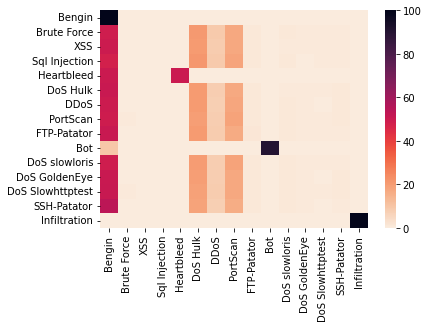

In [ ]:
import seaborn as sns

sns.heatmap(correlation_df, yticklabels = ["Bengin", "Brute Force", "XSS", "Sql Injection", "Heartbleed", "DoS Hulk", "DDoS", "PortScan", "FTP-Patator", "Bot", "DoS slowloris", "DoS GoldenEye", "DoS Slowhttptest", "SSH-Patator", "Infiltration"], xticklabels = ["Bengin", "Brute Force", "XSS", "Sql Injection", "Heartbleed", "DoS Hulk", "DDoS", "PortScan", "FTP-Patator", "Bot", "DoS slowloris", "DoS GoldenEye", "DoS Slowhttptest", "SSH-Patator", "Infiltration"], cmap = sns.cm.rocket_r)

#### Histogramme

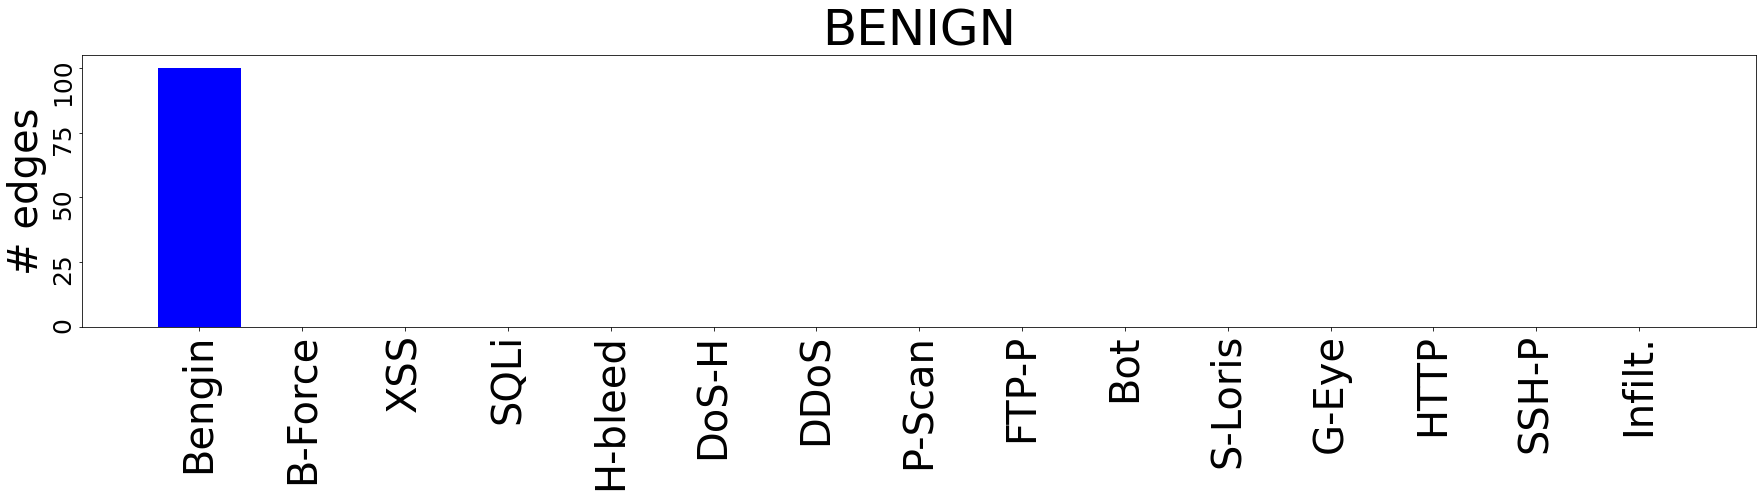

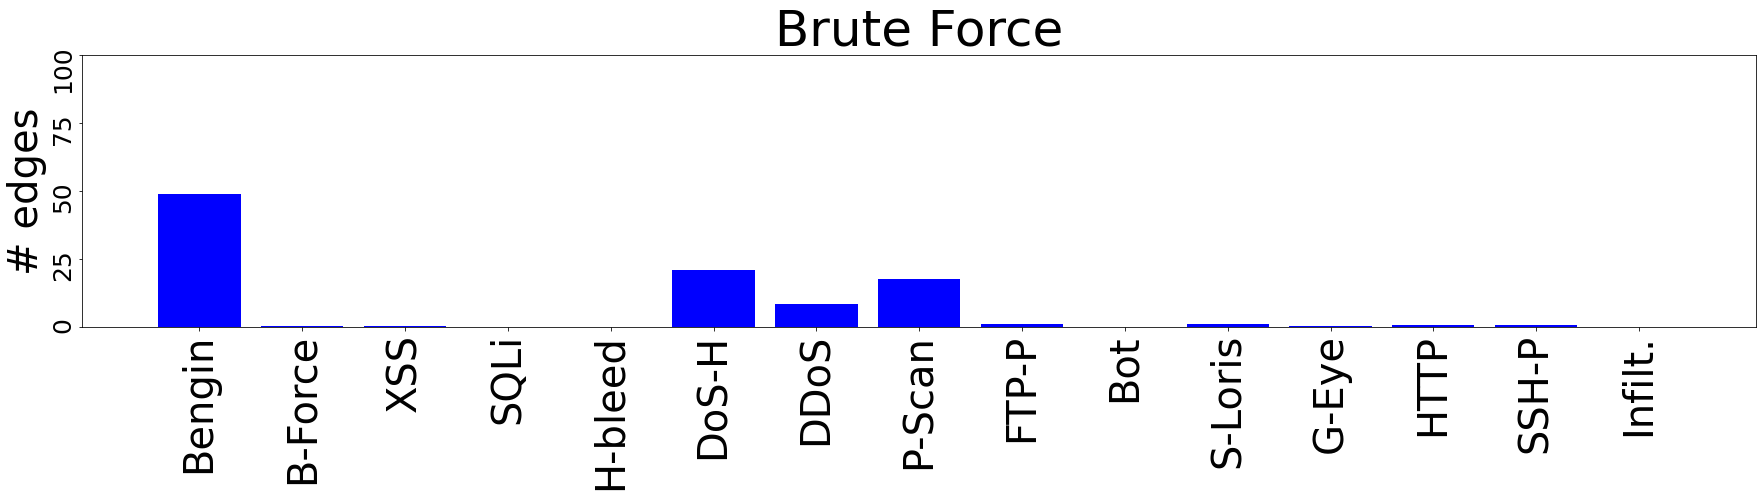

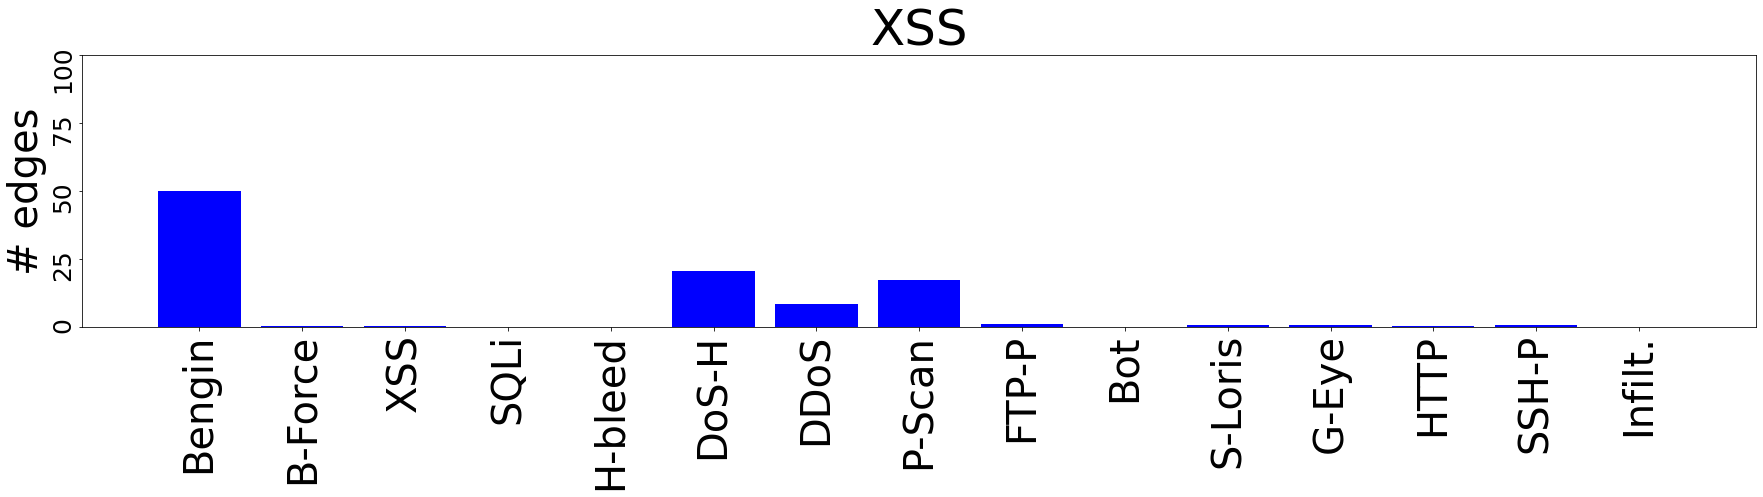

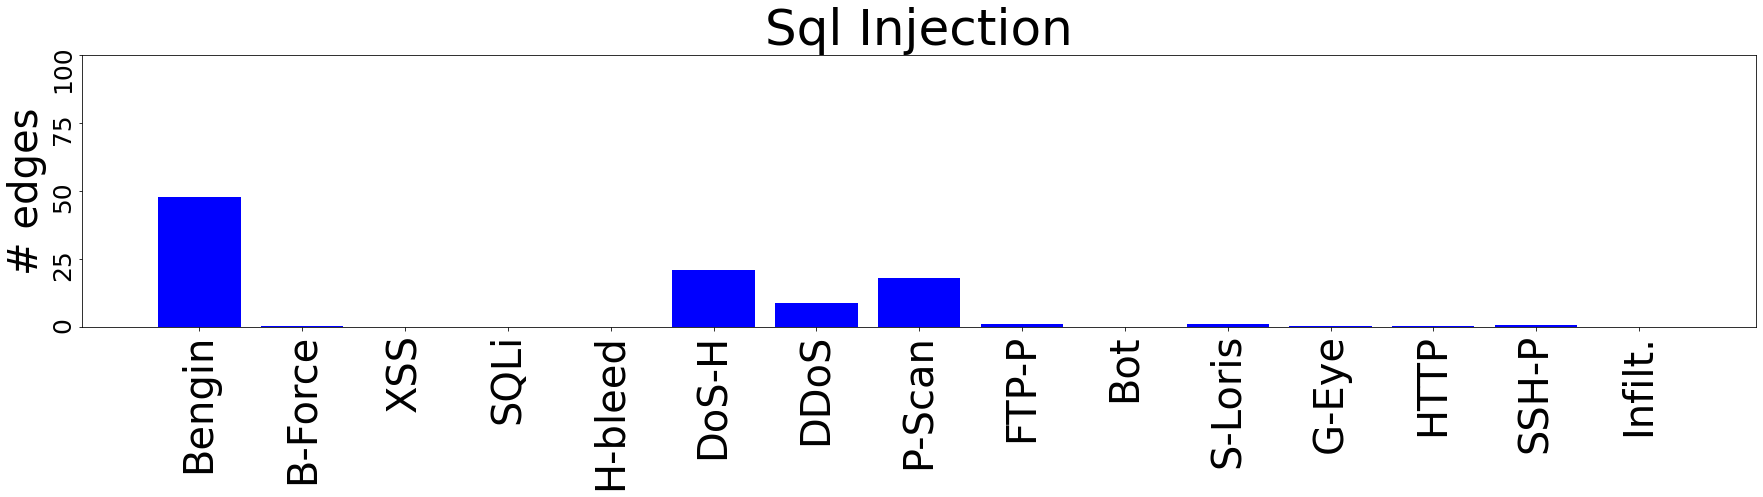

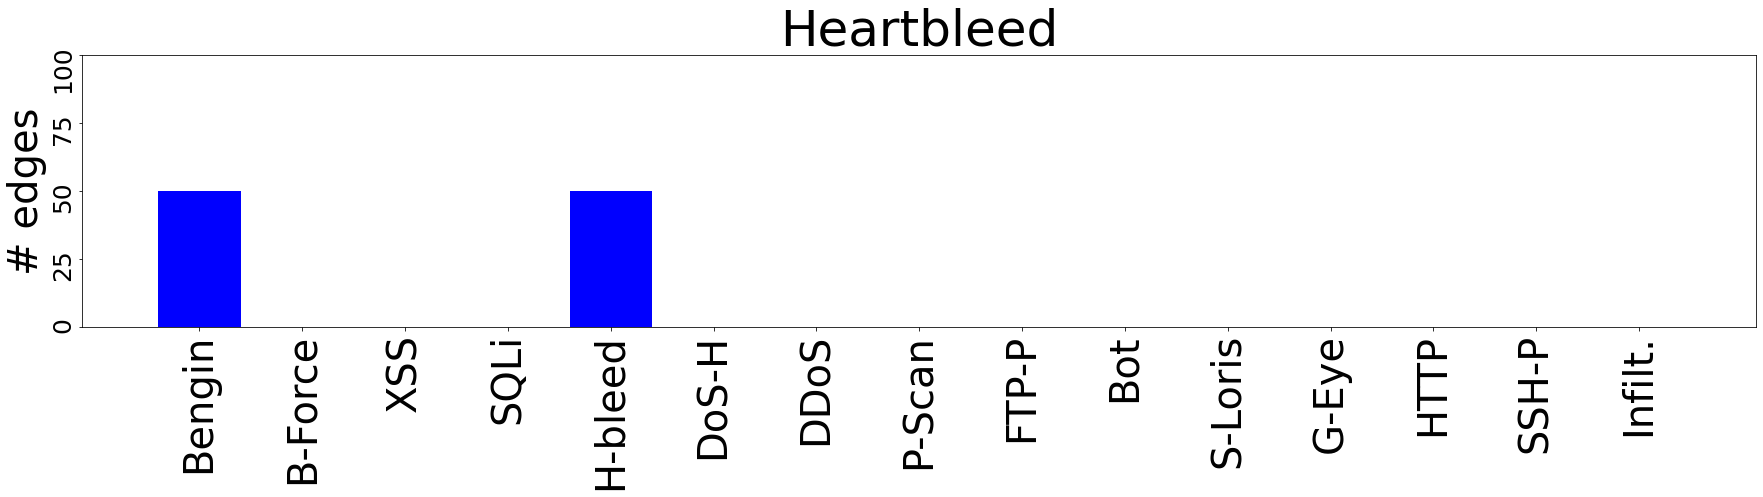

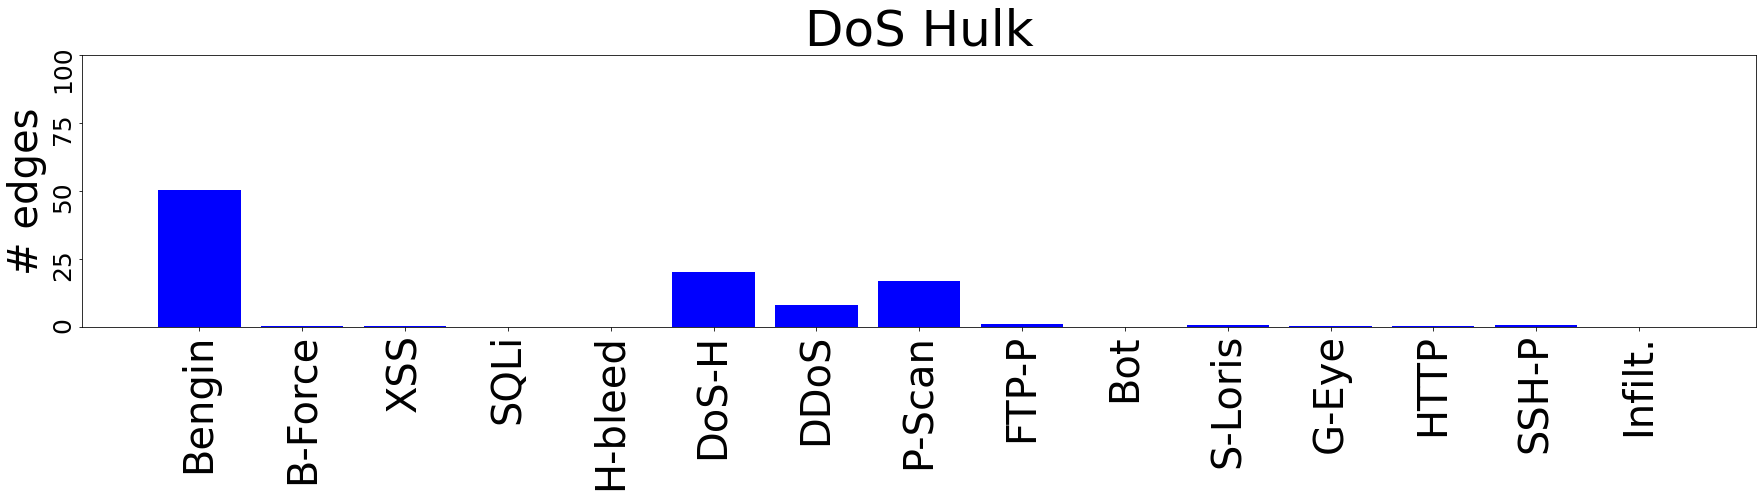

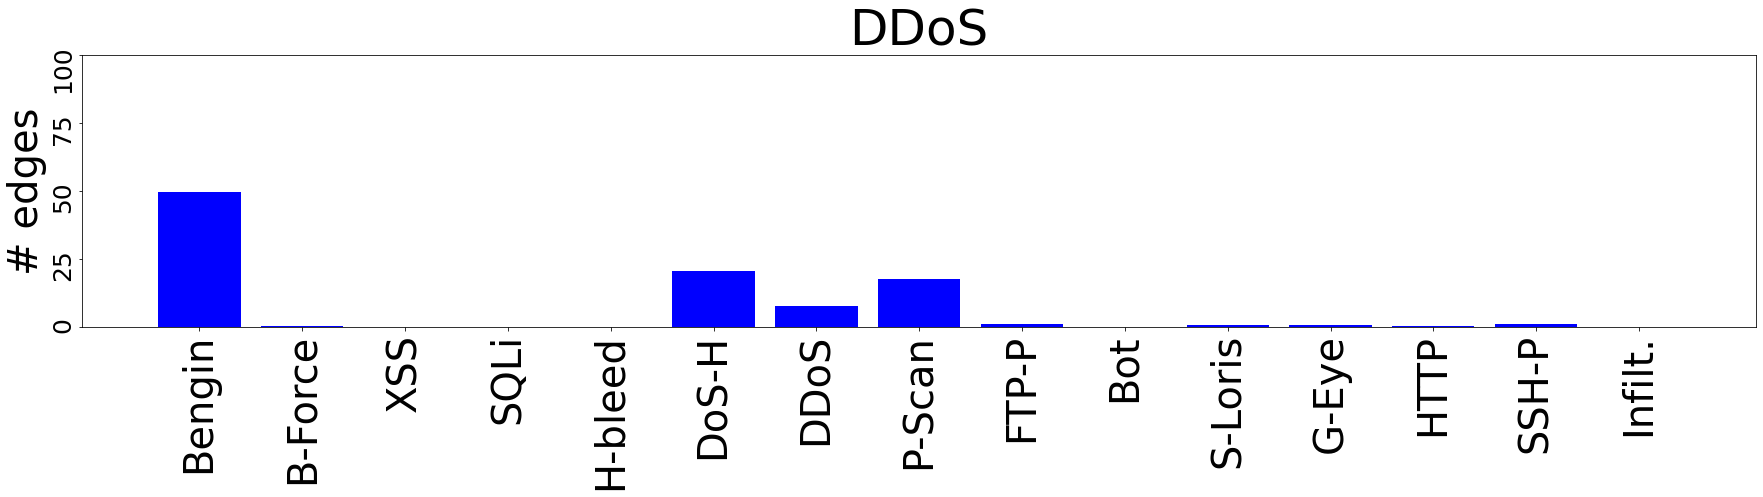

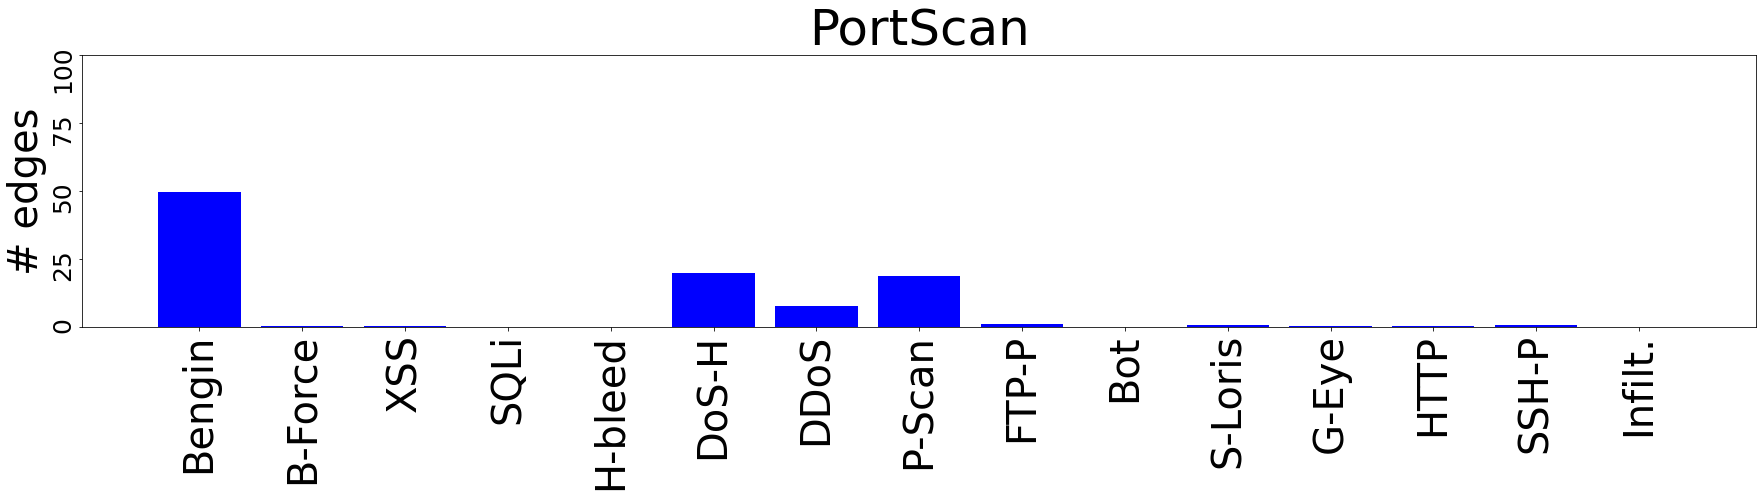

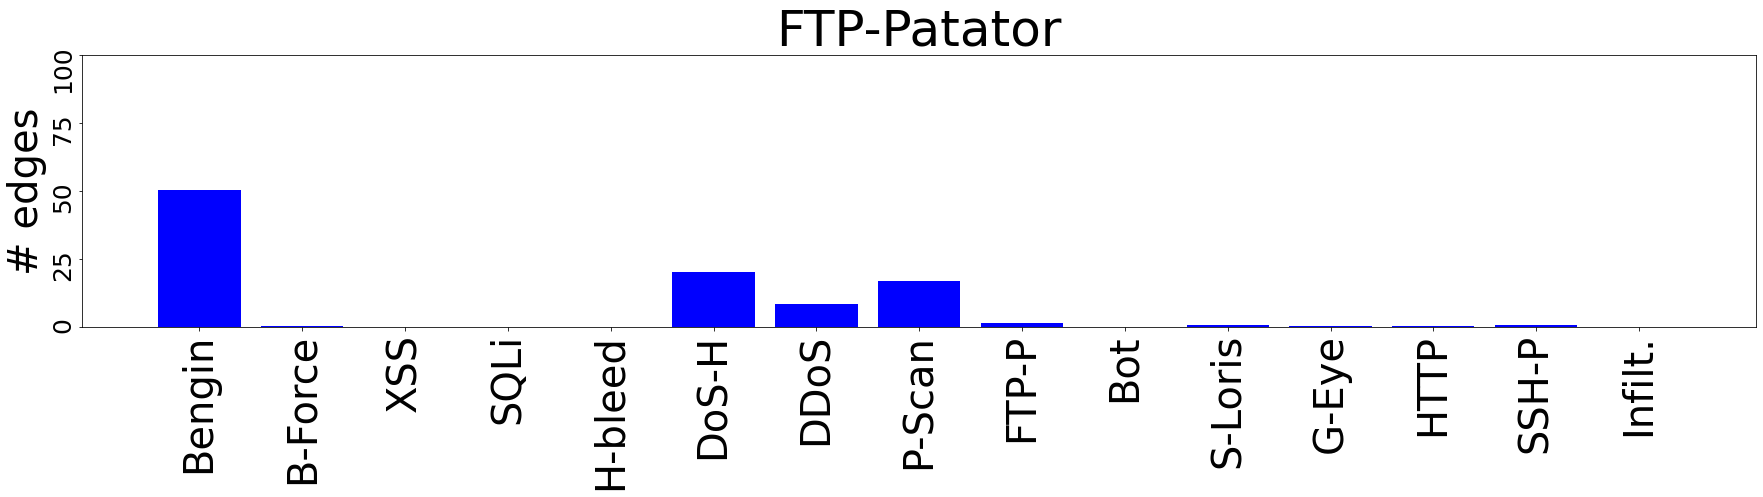

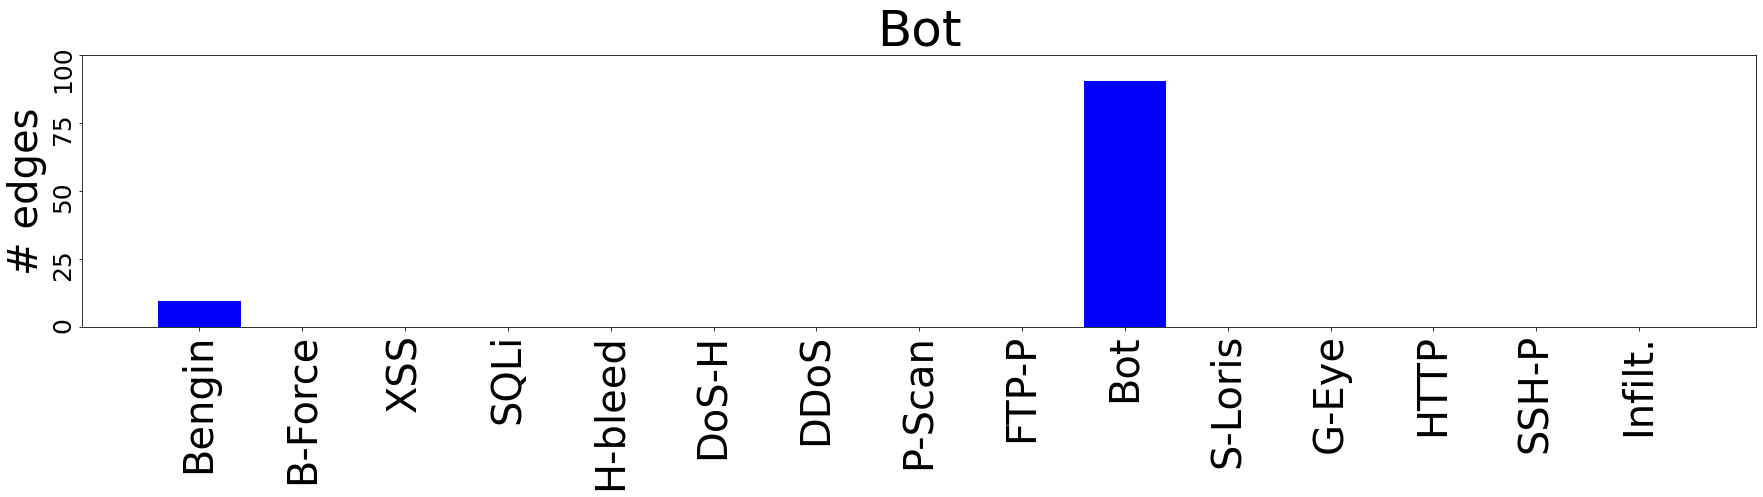

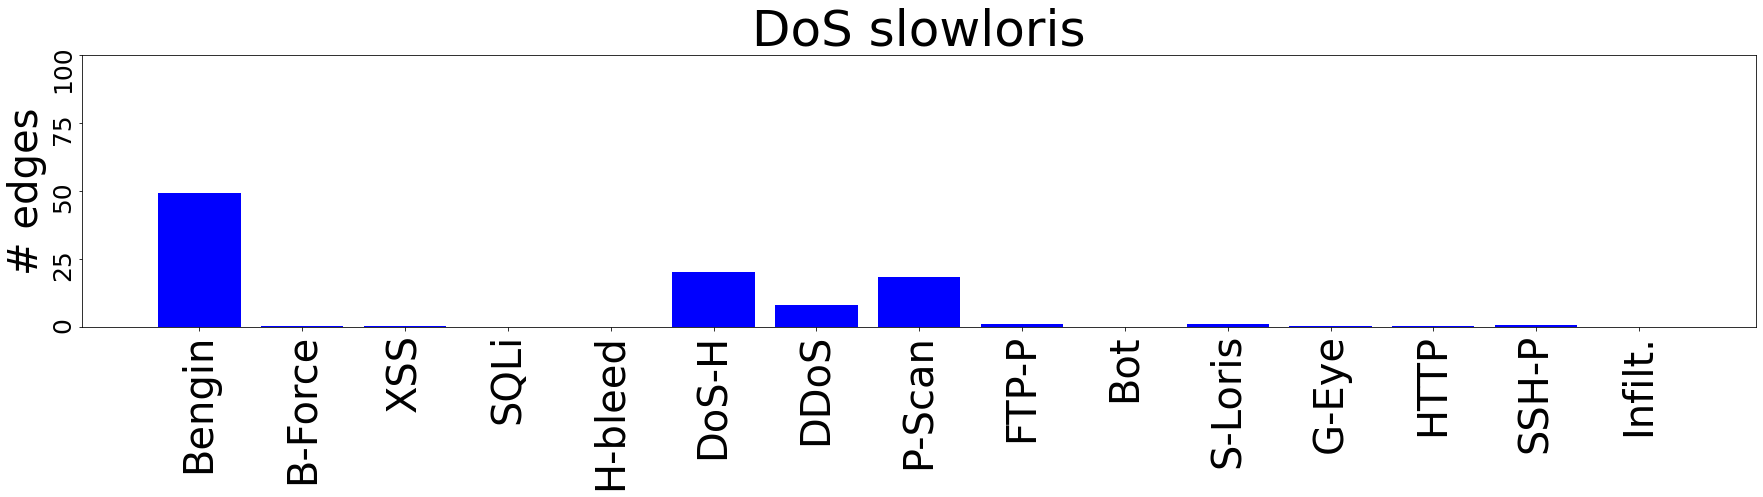

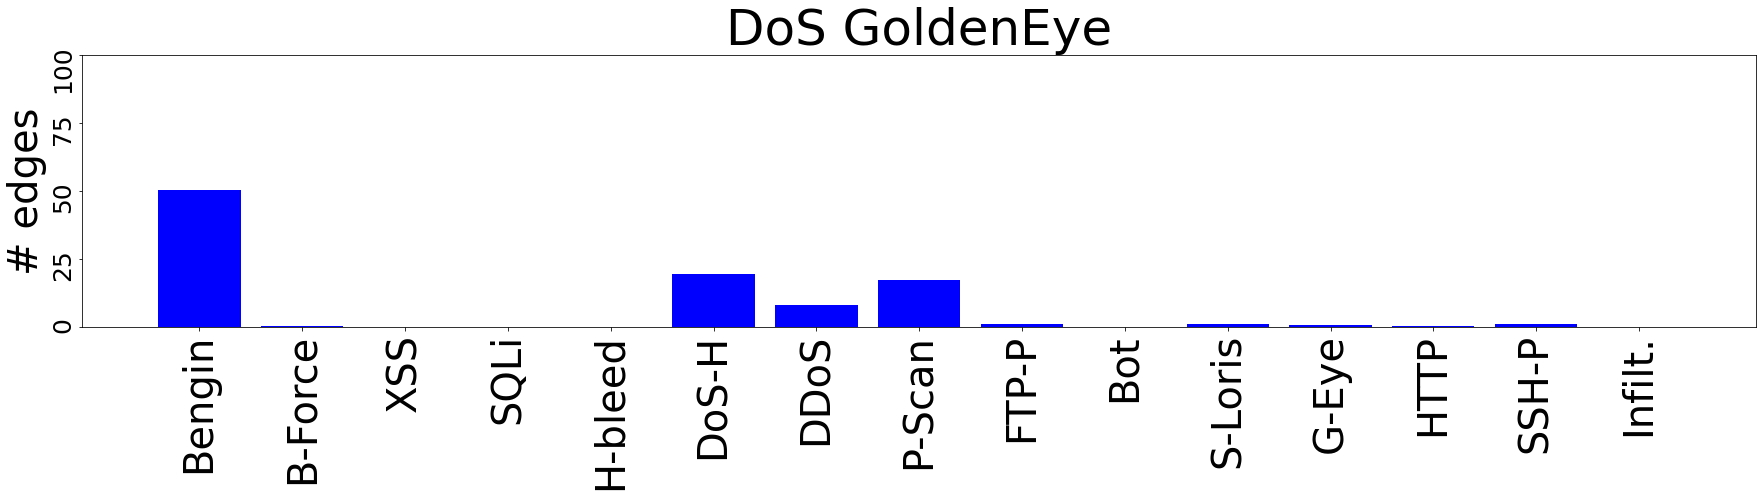

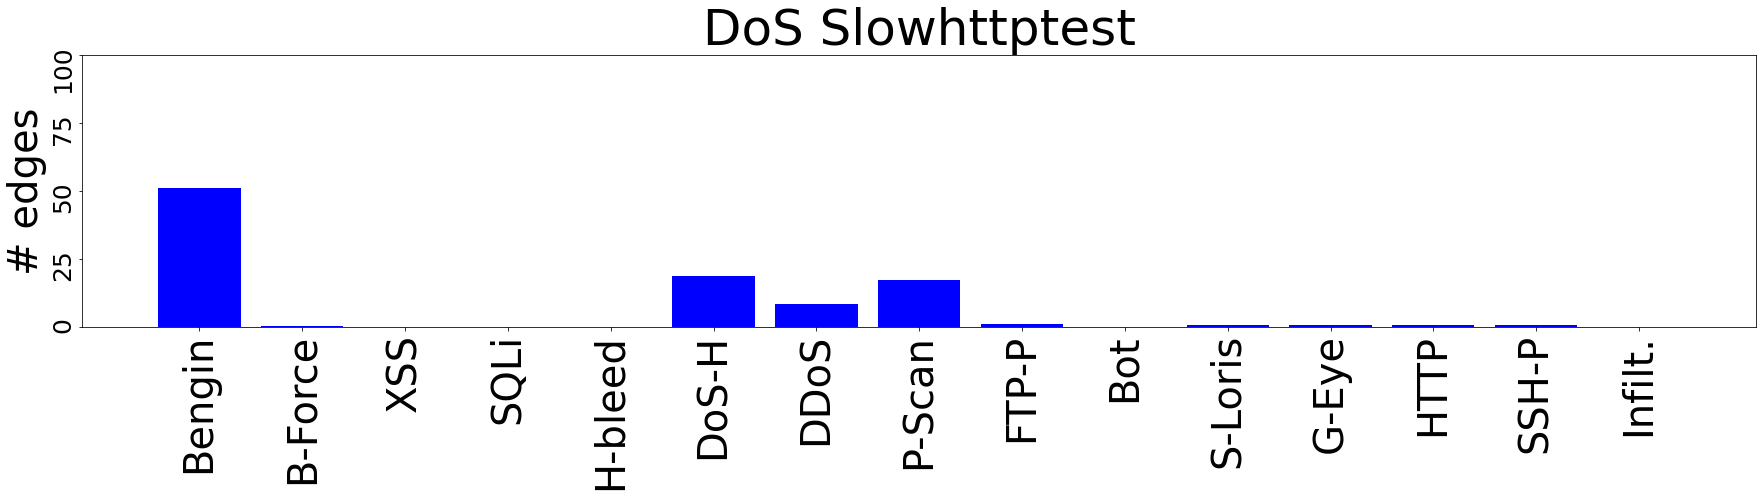

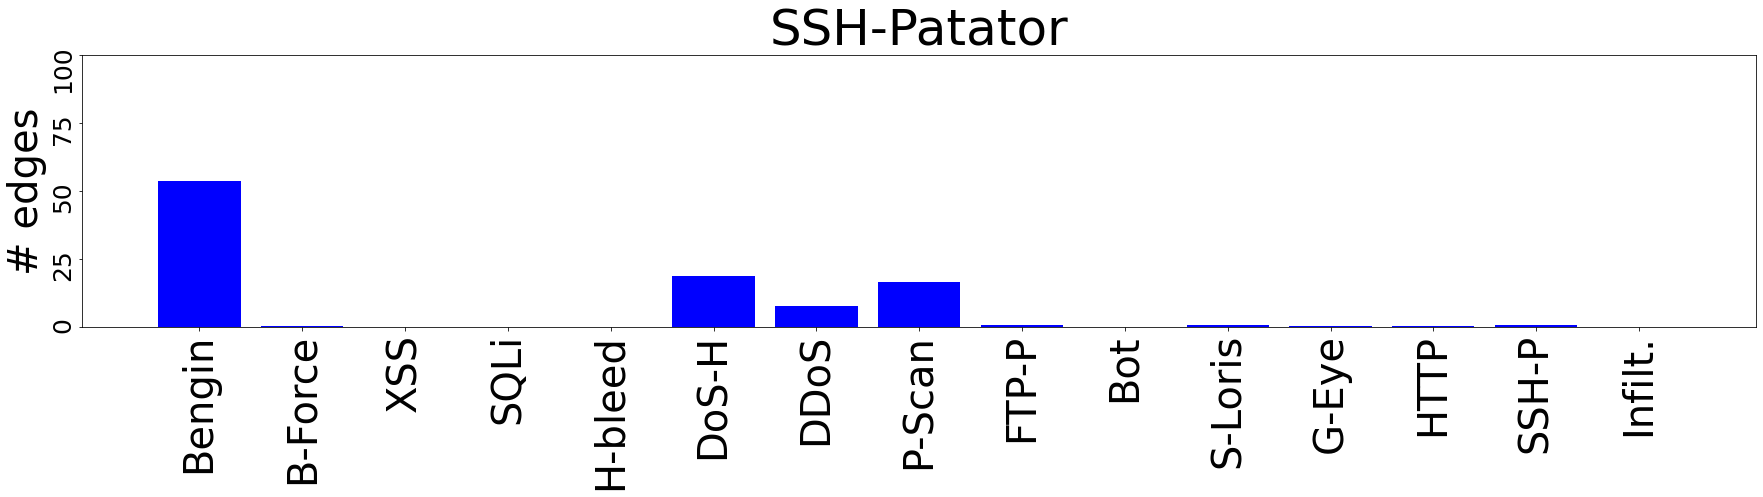

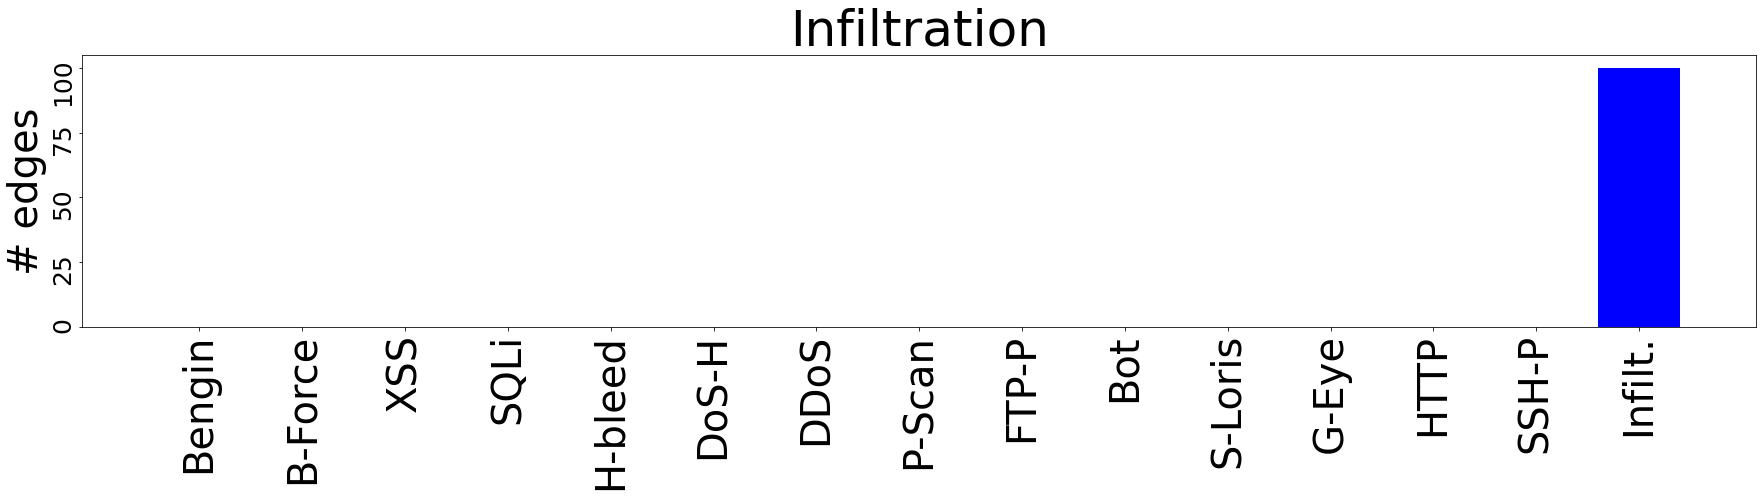

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_axis = ["Bengin", "B-Force", "XSS", "SQLi", "H-bleed", "DoS-H", "DDoS", "P-Scan", "FTP-P", "Bot", "S-Loris", "G-Eye", "HTTP", "SSH-P", "Infilt."]

for indx, row in enumerate(correlation_df.values):
    y_axis = list(row)
    fig = plt.figure(figsize = (30, 5), facecolor = "white")
 
    # creating the bar plot
    plt.bar(x_axis, y_axis, color ='blue', width = 0.8)

    #plt.xlabel("Edge label", fontsize = 20)
    plt.ylabel("# edges", fontsize = 40)
    plt.yticks(np.arange(0, 101, 25), rotation='vertical', fontsize = 25)
    plt.xticks(x_axis, rotation='vertical', ha='center', fontsize = 40)
    plt.title(f"{list(clss_mpping.keys())[indx]}", fontsize = 50)
    
    #ax = plt.gca()
    #ax.tick_params(axis='both', which='major', labelsize = 25)
    plt.show()

### Attack edge

final results : 
edge explained :  7887
edge_mask :  tensor([0.9665, 0.0337, 0.9664, 0.0334, 0.0336, 0.9665, 0.0338, 0.9663, 0.9663,
        0.0336, 0.9663, 0.0334, 0.9666, 0.9663, 0.9666, 0.0337, 0.0337, 0.9662,
        0.9667, 0.9663, 0.9662, 0.9665, 0.0337, 0.0337, 0.9663, 0.0337, 0.0336,
        0.9662, 0.0334, 0.9665, 0.9663, 0.9666, 0.9663, 0.0338, 0.0337, 0.9665,
        0.9663, 0.9662, 0.9663, 0.9666, 0.0337, 0.9667, 0.0338, 0.9665, 0.0338,
        0.9667, 0.0335, 0.9663, 0.0336, 0.9664, 0.9668, 0.0335, 0.0335, 0.9662,
        0.9664, 0.9667, 0.0336, 0.9667, 0.0337, 0.0336, 0.9667, 0.0335, 0.9664,
        0.9662, 0.0335, 0.0334, 0.0334, 0.0333, 0.9664, 0.0336, 0.0335, 0.9664,
        0.9665, 0.0333, 0.9664, 0.9664, 0.9663, 0.0334, 0.0338, 0.9665, 0.0334,
        0.0337, 0.9663, 0.9665, 0.9664, 0.9665, 0.0335, 0.9667, 0.9663, 0.0335,
        0.0337, 0.9664, 0.9663, 0.0333, 0.0338, 0.0336, 0.0336, 0.9667, 0.0335,
        0.0338, 0.0336, 0.9662, 0.0335, 0.9665, 0.9662, 0.9666],
  

{(0, 12): Text(-0.6201745108408248, -0.22303014278159702, 'BENIGN'),
 (0, 10): Text(-0.6126388154415652, -0.23056583818085669, 'BENIGN'),
 (1, 2): Text(-0.4845319936541511, -0.22303014278159705, 'BENIGN'),
 (1, 27): Text(0.2615018508725543, -0.24563722897937598, 'BENIGN'),
 (1, 3): Text(-0.4996033844526704, -0.23810153358011632, 'BENIGN'),
 (13, 0): Text(-0.6051031200423056, -0.23810153358011632, 'BENIGN'),
 (16, 52): Text(-0.3338180856689581, -0.10245901639344263, 'BENIGN'),
 (17, 51): Text(0.05803807509254366, -0.01203067160232683, 'BENIGN'),
 (18, 30): Text(-0.09267583289264933, 0.010576414595452121, 'BENIGN'),
 (22, 30): Text(-0.07760444209413003, 0.0030407191961924693, 'BENIGN'),
 (23, 56): Text(-0.16049709148598618, 0.01811210999471177, 'BENIGN'),
 (24, 30): Text(-0.10021152829190899, 0.018112109994711773, 'BENIGN'),
 (25, 30): Text(-0.10774722369116863, 0.02564780539397142, 'BENIGN'),
 (29, 0): Text(-0.5975674246430459, -0.24563722897937598, 'BENIGN'),
 (30, 11): Text(-0.2132469

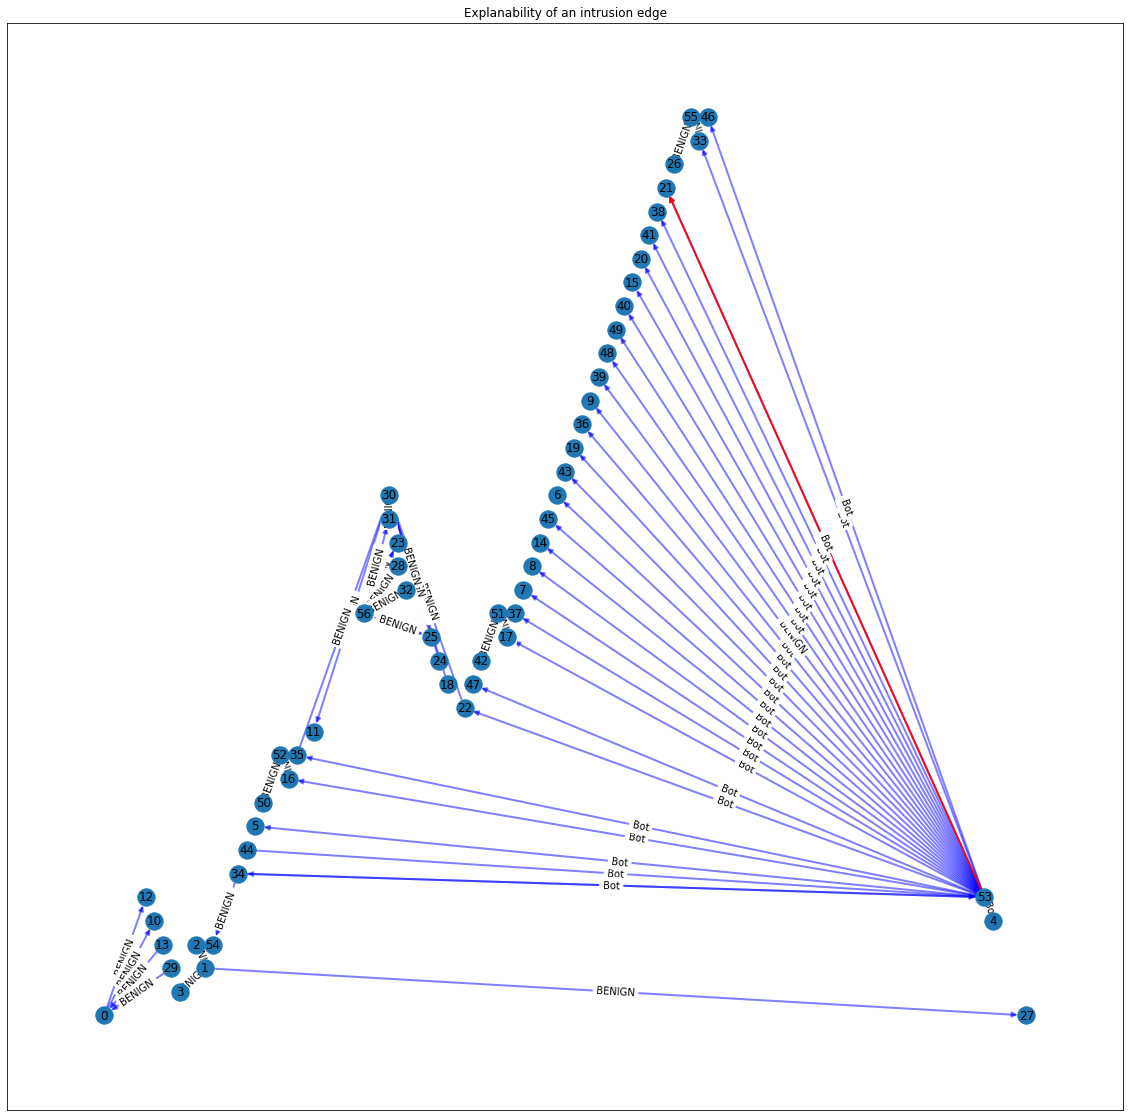

In [29]:
edge_explained = int(min_mutual_info['Edge_indx'].iloc[1])
edge_indice_1, sub_graph_1, edge_mask_1, loss_1 = explain_edges(model1_test, edge_explained, Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge explained : ", edge_explained)
print("edge_mask : ", edge_mask_1)
print("sub_graph : ", sub_graph_1)
print("edge_indice : ", edge_indice_1)
print("loss : ", loss_1)

print('*****************************************************************')
print('Subraph Visualization')

edge_mask_intrusion_round = th.round(edge_mask_1)
unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if edge_indice_1 in unwanted_1:
    unwanted_1.remove(edge_indice_1)

import dgl
g_intrusion = dgl.remove_edges(sub_graph_1, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)

# Edge labels
nx_graph_intrusion_DetailedLabel = nx.get_edge_attributes(nx_graph_intrusion, "DetailedLabel")
keyss = list(nx_graph_intrusion_DetailedLabel.keys())
valuess = list(nx_graph_intrusion_DetailedLabel.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = list(clss_mpping.keys())[list(clss_mpping.values()).index(valuess[indx].item())]
    
# The explained edge
nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == sub_graph_1.edata["Edge_indx"][edge_indice_1].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])


import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[20,20])
plt.title("Explanability of an intrusion edge")
# pos = nx.planar_layout(nx_graph_intrusion)
pos = nx.planar_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss)

### Benign edge

final results : 
edge explained :  8477
edge_mask :  tensor([0.9666, 0.9665, 0.9664, 0.0335, 0.9667, 0.9663, 0.0333, 0.9667, 0.0334,
        0.0336, 0.9662, 0.0338, 0.0333, 0.9665, 0.0334, 0.0333, 0.9667, 0.0334,
        0.9665, 0.0333, 0.9664, 0.0334, 0.0333, 0.0337, 0.0336, 0.9664, 0.9665,
        0.9664, 0.0334, 0.9666, 0.9665, 0.9667, 0.0334, 0.0338, 0.9663, 0.0338,
        0.9666, 0.0332, 0.0338, 0.0333, 0.9664, 0.0336, 0.9662, 0.0337, 0.9665,
        0.9668, 0.9664, 0.9662, 0.9664, 0.0335, 0.0335, 0.9663, 0.0335, 0.0338,
        0.9667, 0.9663, 0.0333, 0.0336, 0.0335, 0.9662, 0.9666, 0.9664, 0.9665,
        0.9667, 0.0334, 0.0335, 0.0333, 0.0338, 0.9668, 0.9662, 0.0337, 0.9667,
        0.0334, 0.0335, 0.9667, 0.9663, 0.0337, 0.9664, 0.9665, 0.0336, 0.0338,
        0.0337, 0.0337, 0.9667, 0.0338, 0.9666, 0.0333, 0.0336, 0.0336, 0.0334,
        0.0337, 0.9663, 0.9665, 0.9665, 0.9664, 0.9664, 0.9665, 0.9667, 0.9667,
        0.0335, 0.0335, 0.0335, 0.9663], device='cuda:0')
sub_graph

{(0, 17): Text(0.3185961428963176, 0.465932009722694, 'BENIGN'),
 (0, 12): Text(0.5992952381379967, 0.4900412837532438, 'BENIGN'),
 (0, 30): Text(0.020253514094218605, -0.14086627850391611, 'BENIGN'),
 (0, 39): Text(0.37289075861366094, -0.48357340415370254, 'BENIGN'),
 (0, 31): Text(0.0394381629906414, -0.19463503224531087, 'BENIGN'),
 (0, 3): Text(0.9709221722123393, 0.1680246885404133, 'BENIGN'),
 (0, 9): Text(0.7581987392855363, 0.428174523803141, 'BENIGN'),
 (0, 51): Text(0.9486991765634112, -0.2206106171015806, 'BENIGN'),
 (1, 7): Text(0.8452096589060195, 0.4155616296876412, 'BENIGN'),
 (1, 4): Text(0.9454400840100641, 0.2776062478987701, 'BENIGN'),
 (1, 47): Text(0.8020648071948981, -0.33895541520455563, 'BENIGN'),
 (1, 14): Text(0.4824628380395773, 0.5567917949525195, 'BENIGN'),
 (1, 38): Text(0.3153369758371649, -0.4089362746173767, 'BENIGN'),
 (1, 35): Text(0.1693105142377308, -0.3208790848699664, 'BENIGN'),
 (1, 21): Text(0.1283702893144132, 0.3950831129711103, 'BENIGN'),
 (

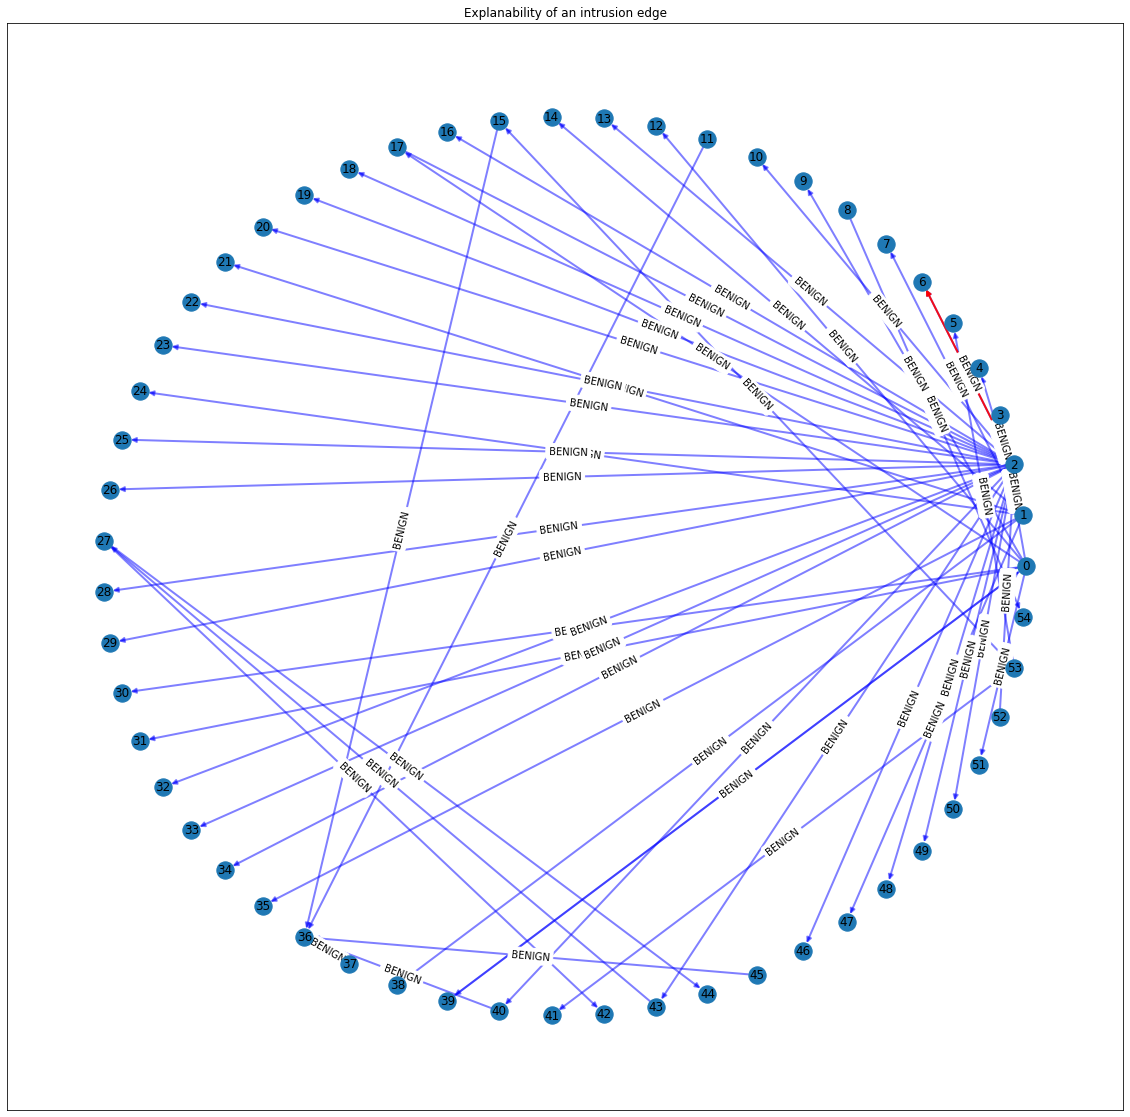

In [7]:
edge_explained = int(min_mutual_info['Edge_indx'].iloc[0])
edge_indice_1, sub_graph_1, edge_mask_1, loss_1 = explain_edges(model1_test, edge_explained, Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge explained : ", edge_explained)
print("edge_mask : ", edge_mask_1)
print("sub_graph : ", sub_graph_1)
print("edge_indice : ", edge_indice_1)
print("loss : ", loss_1)

print('*****************************************************************')
print('Subraph Visualization')

edge_mask_intrusion_round = th.round(edge_mask_1)
unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if edge_indice_1 in unwanted_1:
    unwanted_1.remove(edge_indice_1)

import dgl
g_intrusion = dgl.remove_edges(sub_graph_1, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)

# Edge labels
nx_graph_intrusion_DetailedLabel = nx.get_edge_attributes(nx_graph_intrusion, "DetailedLabel")
keyss = list(nx_graph_intrusion_DetailedLabel.keys())
valuess = list(nx_graph_intrusion_DetailedLabel.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = list(clss_mpping.keys())[list(clss_mpping.values()).index(valuess[indx].item())]
    
# The explained edge
nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == sub_graph_1.edata["Edge_indx"][edge_indice_1].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])


import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[20,20])
plt.title("Explanability of an intrusion edge")
# pos = nx.planar_layout(nx_graph_intrusion)
pos = nx.circular_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss)

### Edge feature explanations

In [8]:
# Local Explanation ***********************************************************************
from math import sqrt
from tqdm import tqdm
from dgl import EID, NID, khop_out_subgraph, khop_in_subgraph

import torch.nn as nn
import torch as th
import dgl


# init mask
def init_efeat_masks(graph, efeat):
    # efeat.size() = torch.Size([nb_edges, 1, 76])
    efeat_size = efeat.size()[2]
    num_edges = graph.num_edges()
    num_nodes = graph.num_nodes()
    device = efeat.device
    std = 0.1
    # feat_mask = [[f1, f2, .... fn]] / n = nb_features
    efeat_mask = nn.Parameter(th.randn(1, efeat_size, device=device) * std)
    std = nn.init.calculate_gain("relu") * sqrt(2.0 / (2 * num_edges))
    # edge_mask = [e1, e2, .... em] / m = nb_edges
    # edge_mask = nn.Parameter(th.randn(num_edges, device=device) * std)
    return efeat_mask


# Regularization loss
def loss_regularize_efeat(loss, feat_mask):
    # epsilon for numerical stability
    eps = 1e-15
    # From self GNNExplainer self
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    #edge_mask = edge_mask.sigmoid()
    # Edge mask sparsity regularization
    #loss = loss + th.from_numpy(alpha1 * th.Tensor.cpu(th.sum(edge_mask)).detach().numpy()).cuda()
    # Edge mask entropy regularization
    #ent = -edge_mask * th.log(edge_mask + eps) - (1 - edge_mask) * th.log(1 - edge_mask + eps)
    #loss = loss + alpha2 * ent.mean()

    feat_mask = feat_mask.sigmoid()
    # Feature mask sparsity regularization
    loss = loss + beta1 * th.mean(feat_mask)
    # Feature mask entropy regularization
    ent = -feat_mask * th.log(feat_mask + eps) - (
        1 - feat_mask
    ) * th.log(1 - feat_mask + eps)
    loss = loss + beta2 * ent.mean()
    return loss



# Edge mask
def explain_edge_features(model, edge_id, graph, node_feat, edge_feat, **kwargs):
    model = model.to(graph.device)
    model.eval()

    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 3
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)
    
    # The edge is added in last position
    sg = dgl.add_edges(sg, inverse_indices.item(), dest_node)
    # So we can add its features in last position
    sg.edata['DetailedLabel'][-1] = graph.edata['DetailedLabel'][edge_id]
    sg.edata['Edge_indx'][-1] = graph.edata['Edge_indx'][edge_id]
    sg.edata['label'][-1] = graph.edata['label'][edge_id]
    sg.edata['h'][-1][0] = graph.edata['h'][edge_id]

    # edge_indice using edge_feature
    #for indx, nd_id in enumerate(sg.edges()[0]):
    #    if inverse_indices == nd_id :
    #        if (sg.edata['h'][indx][0] == edge_h[0]).all() :
    #            edge_indice = indx
    #            break
    
    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break

    # EID = NID = _ID
    # tensor([0, 1, 2, 4]) : nodes and edges ids
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    #print()
    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]
    
    
    # Get the initial prediction.
    #with th.no_grad():
    #    # logits = model(g = sg, nfeats = node_feat, efeats = edge_feat, **kwargs)
    #    logits = model(g = sg, nfeats = node_feat, efeats = edge_feat)
    #    pred_label = logits.argmax(dim=-1)
    
    edge_label_1 = sg.edata["label"][edge_indice]

    # edge_mask
    efeat_mask = init_efeat_masks(sg, edge_feat)
    params = [efeat_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    
    from sklearn.utils import class_weight
    # class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(sg.edata['label'].cpu().numpy()), y = sg.edata['label'].cpu().numpy())
    # class_weights2 = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.array([0, 1]), y = sg.edata['label'].cpu().numpy())
    # class_weights2 = th.FloatTensor(class_weights2).cuda()
    # criterion2 = nn.CrossEntropyLoss(weight = class_weights2)
    criterion2 = nn.CrossEntropyLoss()
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)
    import datetime
    
    #print(f'explanation starts at {datetime.datetime.now()}')
    #print("nb edges : ", sg.num_edges())
    #print("nb nodes : ", sg.num_nodes())
    
    
    for epoch in range(1, 1000):
        optimizer.zero_grad()
        # Apply edge feature mask
        h = edge_feat * efeat_mask.sigmoid()
        # Edge mask
        logits = model(g = sg, nfeats = node_feat, efeats = h).cuda()
        # logits = model(g = sg, nfeats = node_feat, efeats = h)
        # pred_label = tensor([0, 0, 0,  ..., 0, 1, 0], device='cuda:0')
        # logits = tensor([[ 0.0059,  0.0517], [-0.0075,  0.0101], ..., device='cuda:0', grad_fn=<IndexBackward0>)
        # log_probs = logits.log_softmax(dim=-1)
        # loss = -log_probs[edge_indice, pred_label[edge_indice]]
        # loss11 = criterion2(logits[train_mask2], pred_label[train_mask2])
        loss = criterion2(logits[edge_indice], edge_label_1)
        # loss = loss_regularize_efeat(loss11, edge_mask)
        # loss = loss_regularize(loss, efeat_mask, edge_mask)
        
        #if epoch % 100 == 0:
            #print("+++++++++++++++")
            #print(f'epoch number {epoch}, CrossEntropy_Loss = {loss11}, final_loss = {loss}, time = {datetime.datetime.now()}')
            #print("edge_mask : ", edge_mask.detach().sigmoid())
        
        loss.backward()
        optimizer.step()

    efeat_mask = efeat_mask.detach().sigmoid().squeeze()
    return edge_indice, sg, efeat_mask, loss.item()

#### For all the attacks

In [120]:
import pandas as pd

efeat_columns = [' Total Backward Packets', ' Idle Min', ' Subflow Bwd Bytes', ' Fwd Packet Length Min', ' Subflow Bwd Packets', ' Avg Fwd Segment Size', ' Fwd IAT Max', 'Fwd IAT Total', ' Idle Max', 'Total Length of Fwd Packets', 'Bwd Packet Length Max', ' Bwd PSH Flags', 'Bwd Avg Bulk Rate', ' Packet Length Mean', 'Bwd IAT Total', ' Flow IAT Mean', ' Avg Bwd Segment Size', ' Down/Up Ratio', ' Fwd URG Flags', ' Total Length of Bwd Packets', ' URG Flag Count', ' Bwd URG Flags', ' SYN Flag Count', ' Packet Length Variance', ' Active Max', ' Flow IAT Max', ' Bwd IAT Mean', ' Bwd Packet Length Mean', ' Active Std', ' Idle Std', 'Fwd PSH Flags', ' Flow IAT Std', ' Fwd Packet Length Mean', ' Flow IAT Min', ' PSH Flag Count', ' ACK Flag Count', ' act_data_pkt_fwd', ' Init_Win_bytes_backward', ' Bwd Avg Packets/Bulk', 'Subflow Fwd Packets', ' Min Packet Length', ' Bwd Packets/s', ' Fwd Avg Packets/Bulk', ' Fwd Packet Length Std', ' Fwd Avg Bulk Rate', ' Fwd IAT Min', ' Packet Length Std', 'Init_Win_bytes_forward', 'FIN Flag Count', ' Max Packet Length', 'Fwd Packets/s', ' Total Fwd Packets', ' Fwd Header Length', 'Idle Mean', ' Bwd IAT Std', ' Bwd Header Length', ' Bwd IAT Max', ' Subflow Fwd Bytes', ' Fwd Packet Length Max', ' Bwd Packet Length Std', 'Active Mean', ' CWE Flag Count', ' ECE Flag Count', ' Flow Duration', ' Protocol', ' Average Packet Size', ' Fwd IAT Mean', ' Active Min', ' RST Flag Count', ' Bwd Packet Length Min', ' Bwd IAT Min', ' Fwd Header Length.1', ' min_seg_size_forward', ' Fwd IAT Std', 'Fwd Avg Bytes/Bulk', ' Bwd Avg Bytes/Bulk']

efeat_importance_results = pd.DataFrame(columns = ['Attack_type', 'Edge_indice_in_testgraph', 'Edge_indice_in_subgraph', 'Feature_importance'])

for indx, x in enumerate(list(clss_mpping.values())):
    if x != 0:
        print(f'{x} = {list(clss_mpping.keys())[indx]} -> {list((Test_Graph1.edata["DetailedLabel"] == x).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]}')
        attack_type = list(clss_mpping.keys())[indx]
        attack_edge_to_explain = list((Test_Graph1.edata["DetailedLabel"] == x).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]
        
        
        # Explain the edge features
        attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model1_test, attack_edge_to_explain, Test_Graph1, node_features_test1, edge_features_test1)
        
        
        # Analysis of the generated efeat_mask
        # feature_weights_final_attck = pd.DataFrame(columns = ['Feature_name', 'Importance_weight'])
        feature_weights_final_attck = dict()
        for indx, x in enumerate(efeat_columns):
            feature_weights_final_attck[x] = attck_efeat_mask.cpu().detach()[indx].item()
        feature_weights_final_attck = dict(sorted(dict(feature_weights_final_attck).items(), key=lambda item: item[1], reverse=True))
 
        
        # Add results to the DataFrame
        # Attack_type Edge_indice Dependency_freq Graph_path
        efeat_importance_results.loc[-1] = [attack_type, attack_edge_to_explain, attck_edge_indice, feature_weights_final_attck]  # adding a row
        efeat_importance_results.index = efeat_importance_results.index + 1  # shifting index

print("*******************************************************************************************")
print(efeat_importance_results)

1 = Brute Force -> 7205
2 = XSS -> 21601
3 = Sql Injection -> 47370
4 = Heartbleed -> 124271
5 = DoS Hulk -> 0
6 = DDoS -> 3151
7 = PortScan -> 1
8 = FTP-Patator -> 6834
9 = Bot -> 3825
10 = DoS slowloris -> 10167
11 = DoS GoldenEye -> 7734
12 = DoS Slowhttptest -> 6892
13 = SSH-Patator -> 2902
14 = Infiltration -> 49025
*******************************************************************************************
         Attack_type  Edge_indice_in_testgraph  Edge_indice_in_subgraph  \
13       Brute Force                      7205                        0   
12               XSS                     21601                        0   
11     Sql Injection                     47370                        0   
10        Heartbleed                    124271                        0   
9           DoS Hulk                         0                        0   
8               DDoS                      3151                        0   
7           PortScan                         1              

In [121]:
# efeat_importance_results.to_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/Most_Important_Files/efeat_importance_results.csv', sep=',', index = False)

In [59]:
import pandas as pd

efeat_importance_results = pd.read_csv(f'/home/ahmed/GNN-Based-ANIDS/GNN-Based-ANIDS/jupyter_notebooks/XAI/GNNExplainer/Most_Important_Files/efeat_importance_results.csv', encoding="ISO-8859–1", dtype = str)

In [60]:
categ_features = {' Average Packet Size': 6,
 ' Subflow Bwd Bytes': 3,
 ' Avg Bwd Segment Size': 6,
 'Subflow Fwd Packets': 3,
 ' Bwd Header Length': 9,
 ' Fwd Header Length.1': 9,
 ' ECE Flag Count': 2,
 ' Fwd IAT Min': 0,
 ' CWE Flag Count': 2,
 ' Idle Max': 7,
 ' Max Packet Length': 6,
 ' Flow IAT Min': 2,
 ' Fwd Avg Packets/Bulk': 2,
 ' Bwd Packet Length Std': 6,
 'Fwd PSH Flags': 2,
 'Fwd Packets/s': 2,
 ' Fwd IAT Max': 7,
 ' Bwd Avg Bytes/Bulk': 2,
 ' Packet Length Mean': 6,
 ' Packet Length Std': 6,
 ' Idle Min': 7,
 ' Bwd Packets/s': 2,
 ' Active Max': 8,
 ' Active Min': 8,
 'Idle Mean': 7,
 ' Fwd Avg Bulk Rate': 2,
 ' Bwd Packet Length Min': 1,
 'Bwd IAT Total': 4,
 ' Bwd IAT Min': 0,
 ' Bwd IAT Std': 4,
 ' Flow Duration': 4,
 'Fwd Avg Bytes/Bulk': 2,
 ' RST Flag Count': 2,
 ' Idle Std': 2,
 ' Bwd IAT Mean': 0,
 ' Init_Win_bytes_backward': 2,
 ' Protocol': 1,
 ' Avg Fwd Segment Size': 5,
 ' Total Length of Bwd Packets': 3,
 ' Fwd Packet Length Min': 2,
 'Init_Win_bytes_forward': 2,
 ' Flow IAT Max': 7,
 ' Total Backward Packets': 3,
 ' act_data_pkt_fwd': 3,
 ' Flow IAT Mean': 0,
 ' Subflow Fwd Bytes': 2,
 ' Total Fwd Packets': 3,
 'Bwd Avg Bulk Rate': 2,
 'Active Mean': 8,
 ' Min Packet Length': 1,
 'Total Length of Fwd Packets': 2,
 ' Fwd Packet Length Mean': 5,
 ' Bwd PSH Flags': 2,
 ' SYN Flag Count': 2,
 ' Bwd IAT Max': 4,
 ' Flow IAT Std': 7,
 ' URG Flag Count': 2,
 ' Fwd Packet Length Std': 5,
 ' Fwd IAT Std': 7,
 ' Active Std': 8,
 ' min_seg_size_forward': 9,
 'Bwd Packet Length Max': 6,
 ' Fwd Header Length': 9,
 ' Bwd URG Flags': 2,
 ' Fwd URG Flags': 2,
 ' Bwd Avg Packets/Bulk': 2,
 ' Down/Up Ratio': 2,
 ' PSH Flag Count': 1,
 'Fwd IAT Total': 4,
 ' Bwd Packet Length Mean': 6,
 ' Packet Length Variance': 6,
 ' Fwd IAT Mean': 0,
 ' ACK Flag Count': 1,
 'FIN Flag Count': 1,
 ' Subflow Bwd Packets': 3,
 ' Fwd Packet Length Max': 5}

print(categ_features)

{' Average Packet Size': 6, ' Subflow Bwd Bytes': 3, ' Avg Bwd Segment Size': 6, 'Subflow Fwd Packets': 3, ' Bwd Header Length': 9, ' Fwd Header Length.1': 9, ' ECE Flag Count': 2, ' Fwd IAT Min': 0, ' CWE Flag Count': 2, ' Idle Max': 7, ' Max Packet Length': 6, ' Flow IAT Min': 2, ' Fwd Avg Packets/Bulk': 2, ' Bwd Packet Length Std': 6, 'Fwd PSH Flags': 2, 'Fwd Packets/s': 2, ' Fwd IAT Max': 7, ' Bwd Avg Bytes/Bulk': 2, ' Packet Length Mean': 6, ' Packet Length Std': 6, ' Idle Min': 7, ' Bwd Packets/s': 2, ' Active Max': 8, ' Active Min': 8, 'Idle Mean': 7, ' Fwd Avg Bulk Rate': 2, ' Bwd Packet Length Min': 1, 'Bwd IAT Total': 4, ' Bwd IAT Min': 0, ' Bwd IAT Std': 4, ' Flow Duration': 4, 'Fwd Avg Bytes/Bulk': 2, ' RST Flag Count': 2, ' Idle Std': 2, ' Bwd IAT Mean': 0, ' Init_Win_bytes_backward': 2, ' Protocol': 1, ' Avg Fwd Segment Size': 5, ' Total Length of Bwd Packets': 3, ' Fwd Packet Length Min': 2, 'Init_Win_bytes_forward': 2, ' Flow IAT Max': 7, ' Total Backward Packets': 3, '

In [61]:
import numpy as np

efeat_correlation_df = pd.DataFrame(columns = ["Categorie 0", "Categorie 1", "Categorie 2", "Categorie 3", "Categorie 4", "Categorie 5", "Categorie 6", "Categorie 7", "Categorie 8", "Categorie 9"])

benign_efeat_imp = {' Subflow Bwd Bytes': 0.576703, ' Bwd Packet Length Min': 0.562913, 'Idle Mean': 0.548867, 
                    ' Avg Bwd Segment Size': 0.541600, ' Fwd Packet Length Max': 0.535543, ' Packet Length Variance': 0.534765,
                    ' Active Std': 0.533494, ' Bwd Avg Bytes/Bulk': 0.531683, ' Subflow Bwd Packets': 0.531668,
                    ' Average Packet Size': 0.531412}

efeat_array_to_insert = list(np.zeros(10))

for x in list(benign_efeat_imp.keys()):
    efeat_array_to_insert[categ_features[x]] = efeat_array_to_insert[categ_features[x]] + 1

efeat_correlation_df.loc[-1] = efeat_array_to_insert  # adding a row
efeat_correlation_df.index = efeat_correlation_df.index + 1  # shifting index


bot_efeat_imp = {' Protocol': 0.969751, ' Fwd Packet Length Min': 0.963157, ' Max Packet Length': 0.960226,
                 ' Bwd Packet Length Min': 0.954250, ' Min Packet Length': 0.953229, ' PSH Flag Count': 0.944505,
                 ' ECE Flag Count': 0.935783, ' RST Flag Count': 0.909857, ' Active Std': 0.904808,
                 ' Packet Length Variance': 0.878375}


for indx, efeat_imp in enumerate(efeat_importance_results['Feature_importance']):
    if indx == 8:
        efeat_array_to_insert = list(np.zeros(10))
        for x in list(bot_efeat_imp.keys())[0:10]:
            efeat_array_to_insert[categ_features[x]] = efeat_array_to_insert[categ_features[x]] + 1

        efeat_correlation_df.loc[-1] = efeat_array_to_insert  # adding a row
        efeat_correlation_df.index = efeat_correlation_df.index + 1  # shifting index

    else:
        efeat_array_to_insert = list(np.zeros(10))
        efeat_imp_dict = eval(efeat_imp)
        for x in list(efeat_imp_dict.keys())[0:10]:
            efeat_array_to_insert[categ_features[x]] = efeat_array_to_insert[categ_features[x]] + 1

        efeat_correlation_df.loc[-1] = efeat_array_to_insert  # adding a row
        efeat_correlation_df.index = efeat_correlation_df.index + 1  # shifting index

print(efeat_correlation_df)

    Categorie 0  Categorie 1  Categorie 2  Categorie 3  Categorie 4  \
14          0.0          1.0          1.0          2.0          0.0   
13          0.0          1.0          0.0          3.0          0.0   
12          0.0          1.0          0.0          4.0          0.0   
11          0.0          0.0          0.0          4.0          0.0   
10          0.0          1.0          0.0          5.0          0.0   
9           0.0          1.0          0.0          3.0          0.0   
8           0.0          0.0          0.0          4.0          0.0   
7           0.0          1.0          0.0          4.0          0.0   
6           0.0          1.0          1.0          4.0          0.0   
5           0.0          4.0          3.0          0.0          0.0   
4           0.0          1.0          0.0          5.0          0.0   
3           0.0          1.0          0.0          4.0          0.0   
2           0.0          0.0          0.0          4.0          0.0   
1     

#### Histogramme

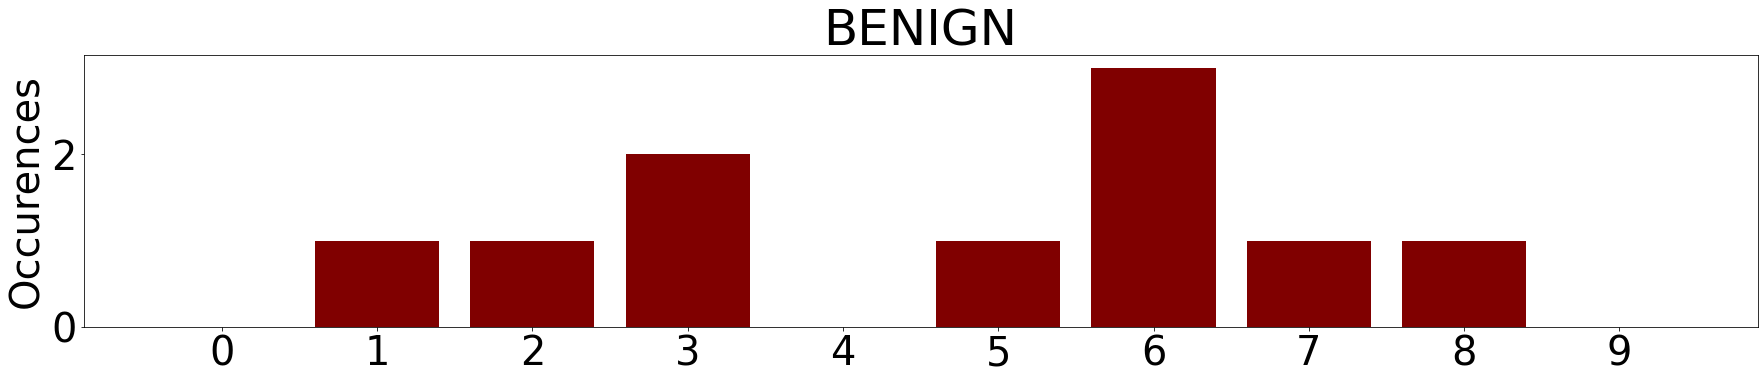

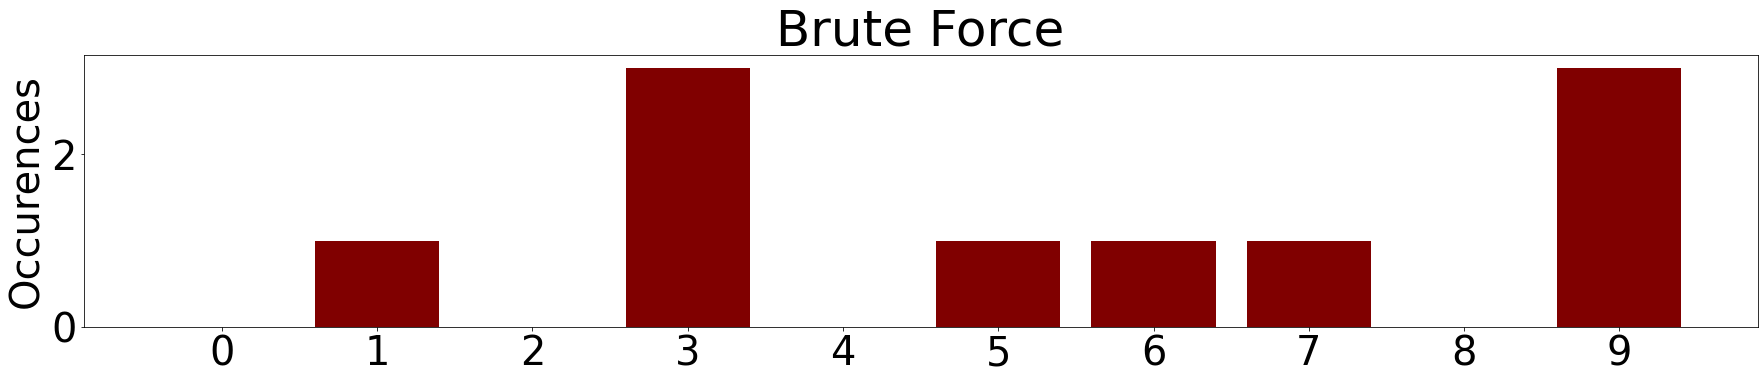

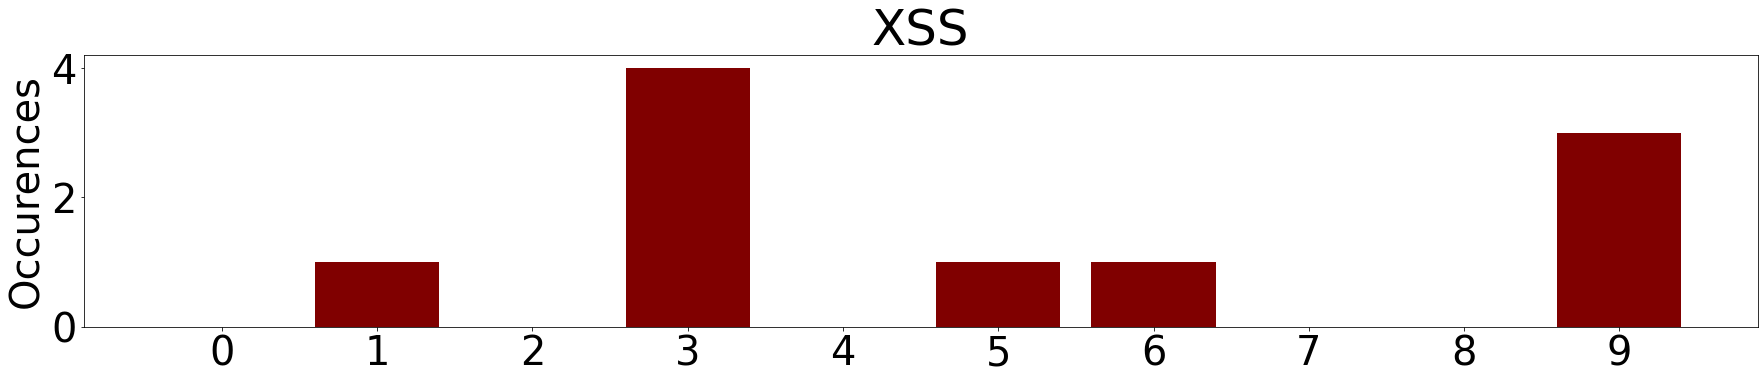

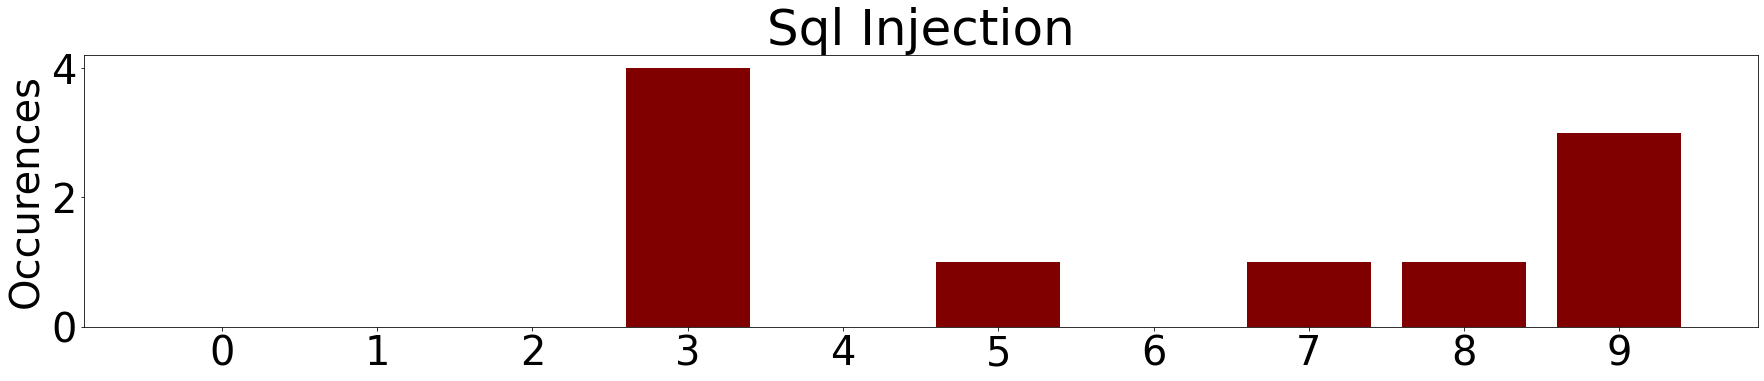

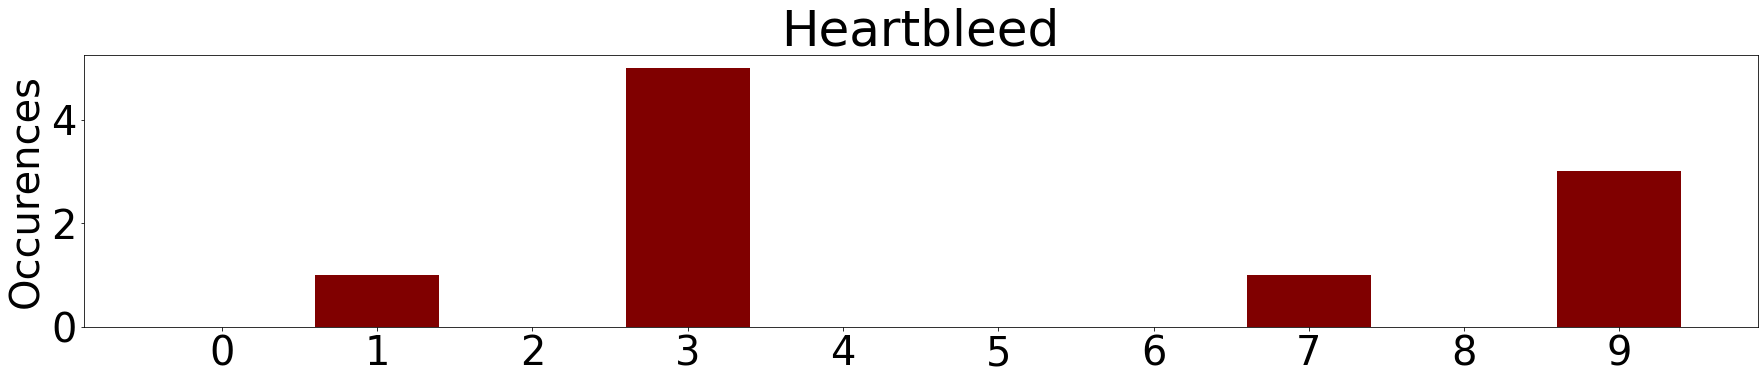

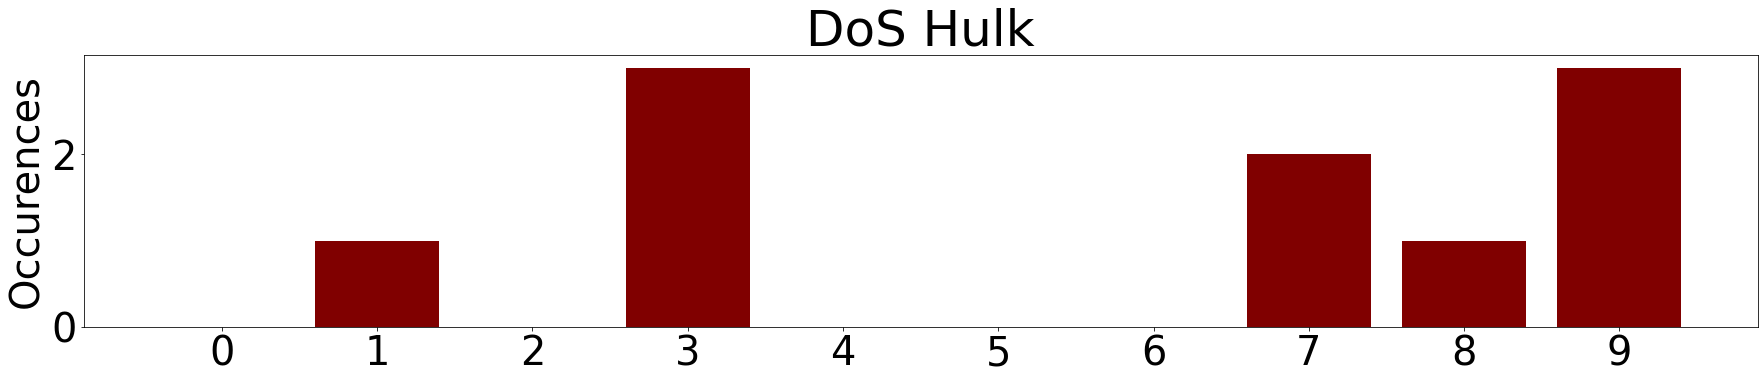

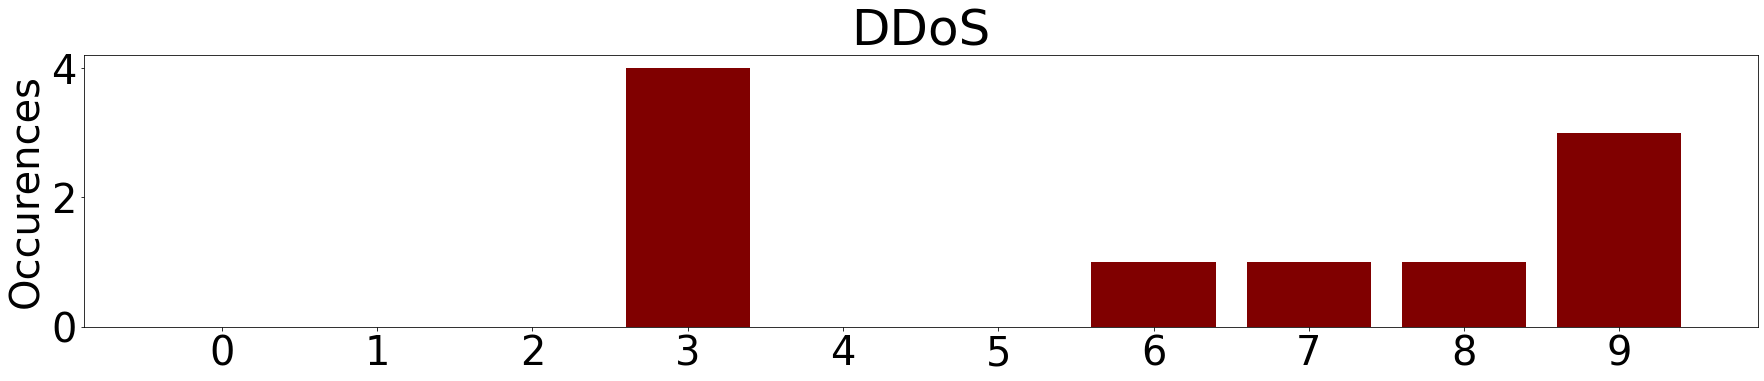

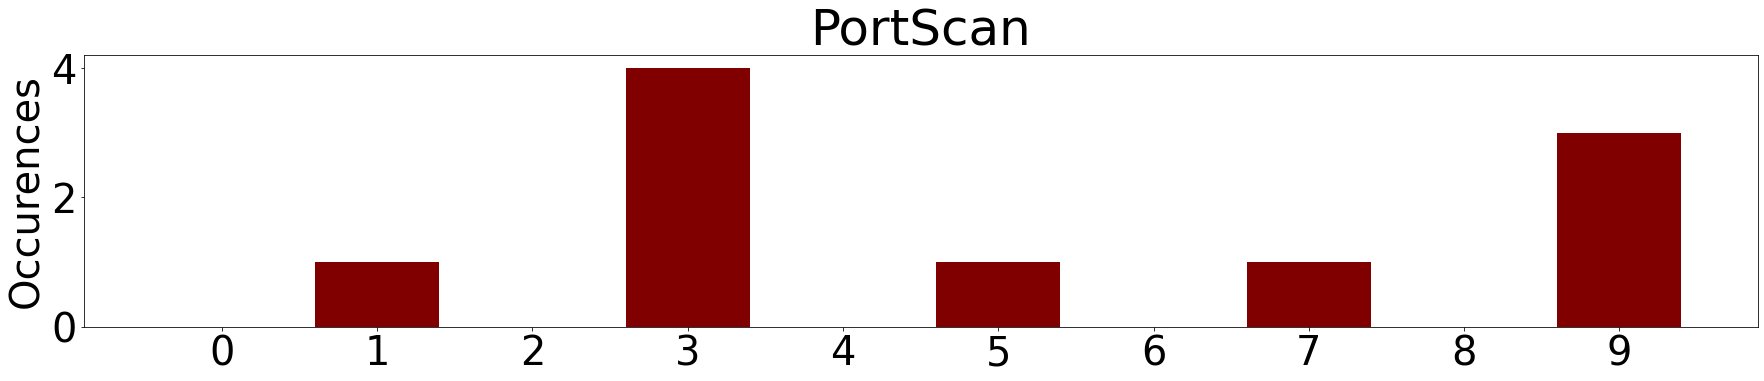

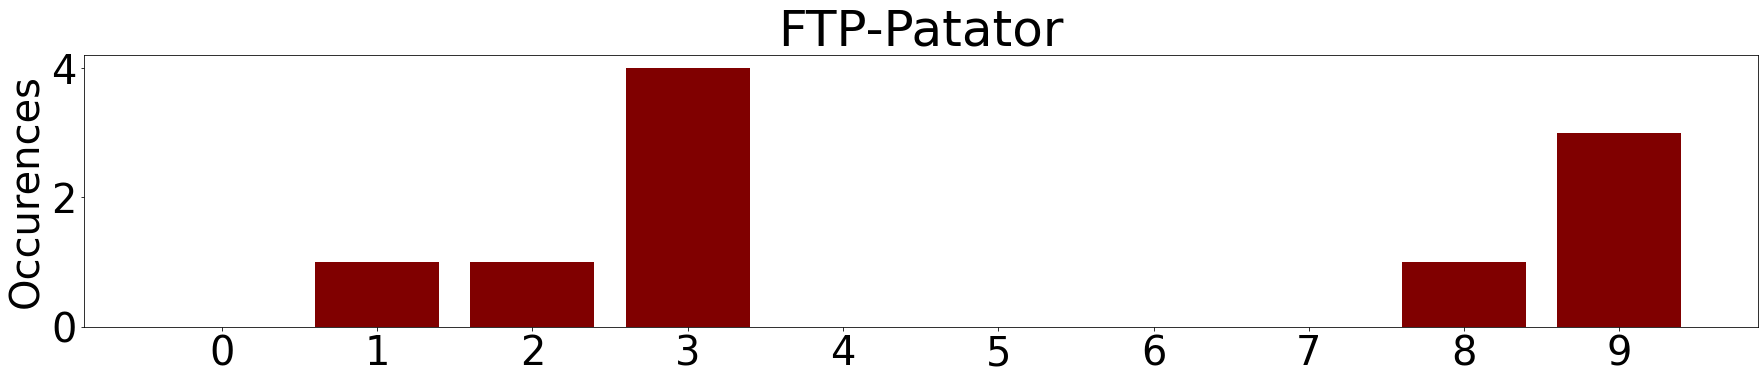

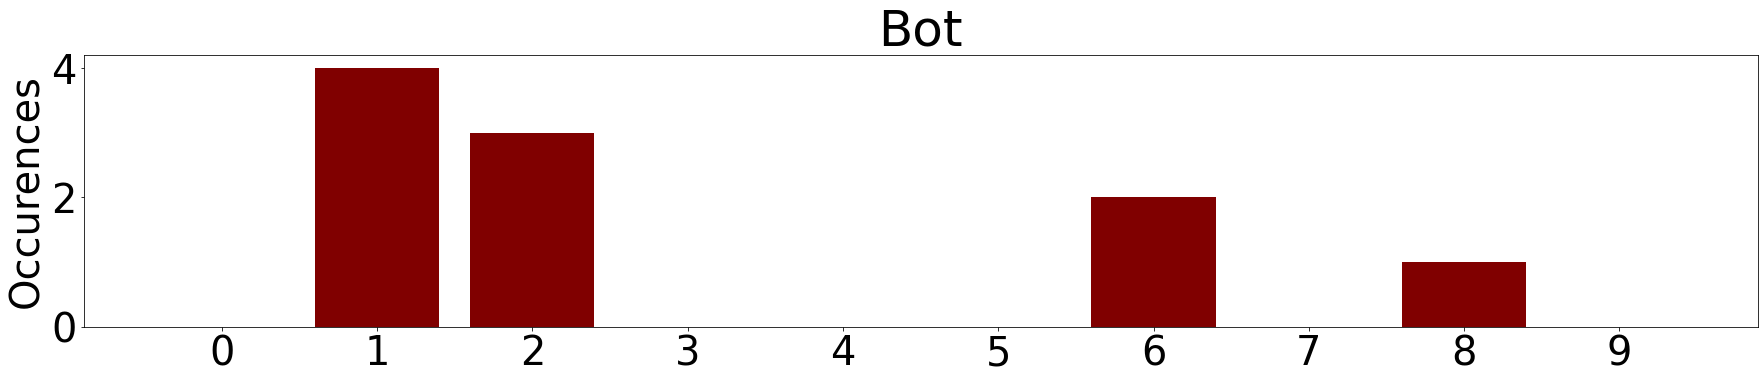

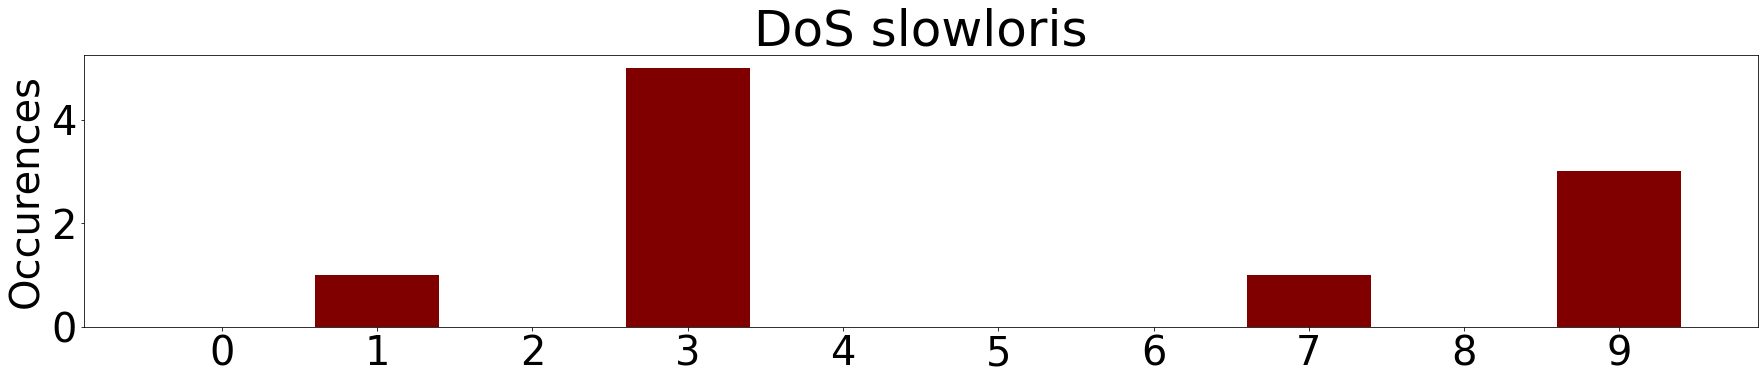

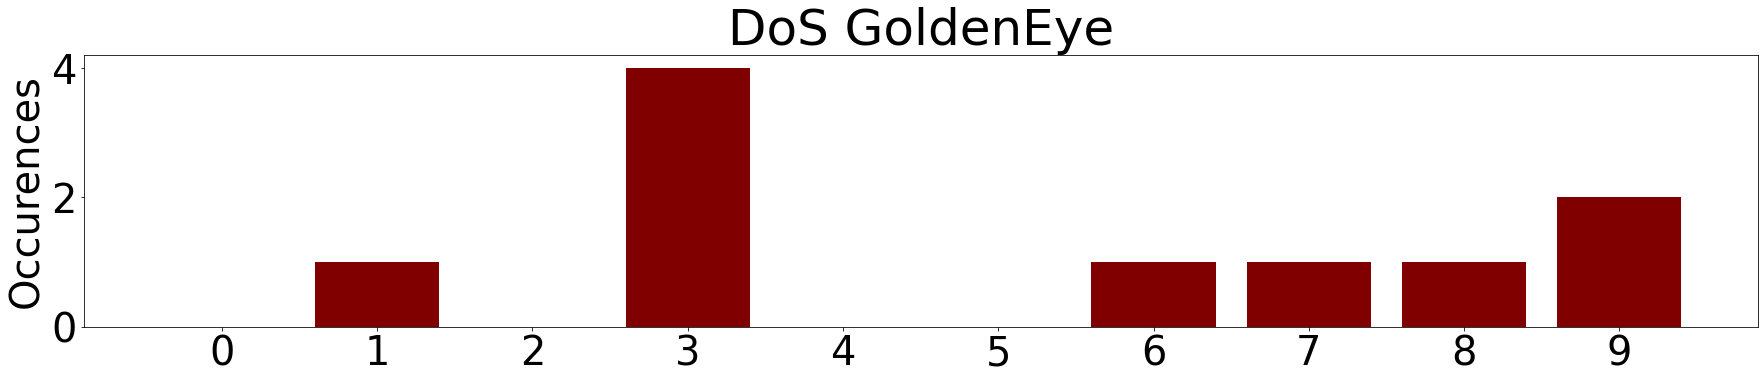

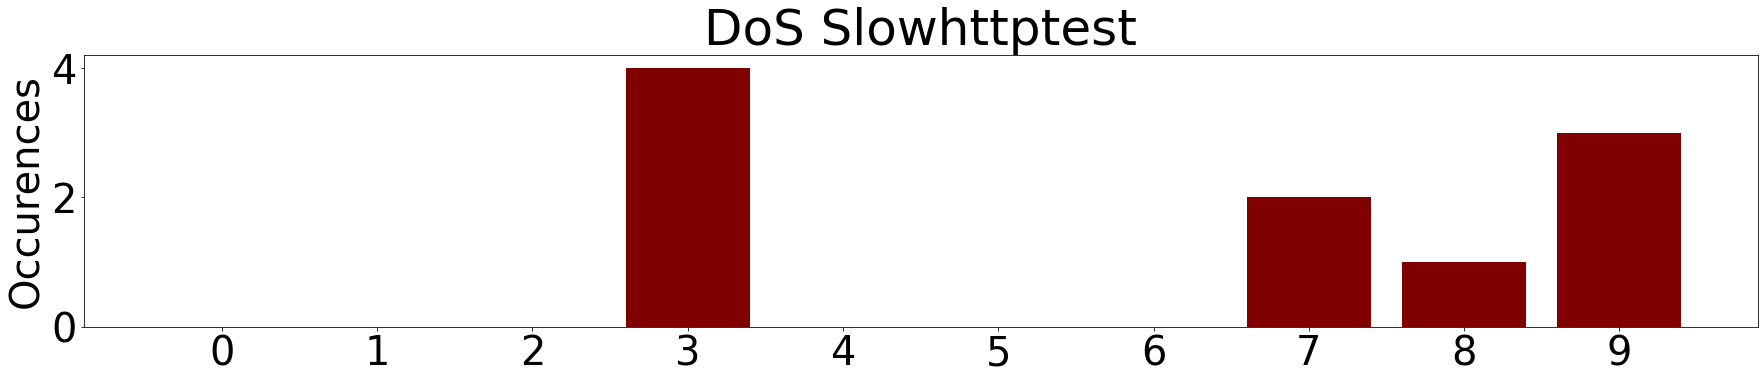

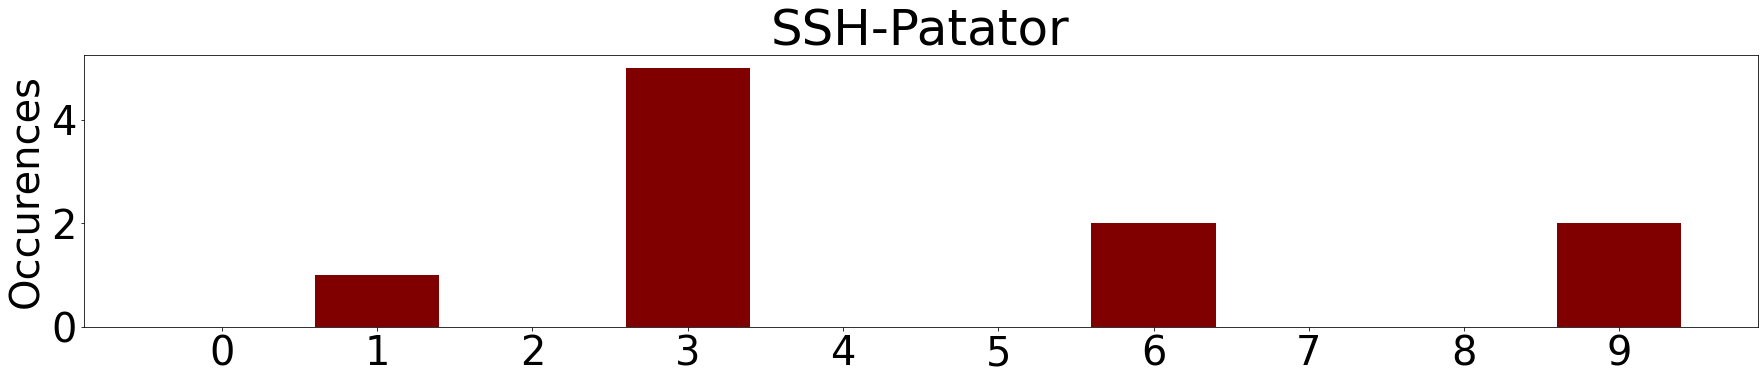

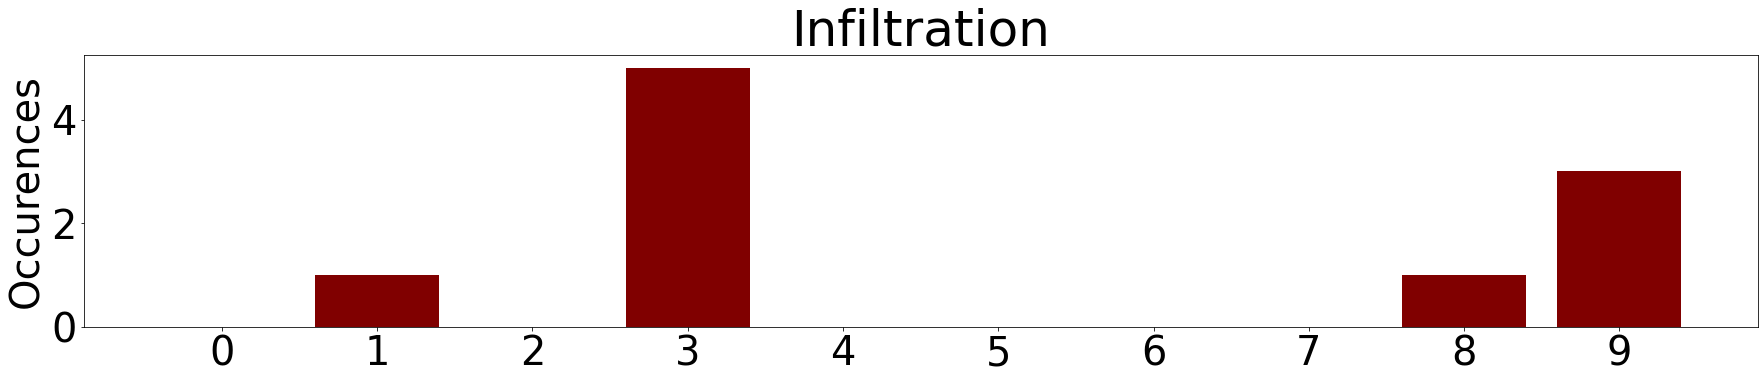

In [98]:
import numpy as np
import matplotlib.pyplot as plt

x_axis = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

for indx, row in enumerate(efeat_correlation_df.values):
    y_axis = list(row)
    fig = plt.figure(figsize = (30, 5), facecolor = "white")
 
    # creating the bar plot
    plt.bar(x_axis, y_axis, color ='maroon', width = 0.8)

    # plt.xlabel("Clusters", fontsize = 40)
    plt.ylabel("Occurences", fontsize = 40)
    plt.title(f"{list(clss_mpping.keys())[indx]}", fontsize = 50)
    
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize = 40)
    plt.show()

### Attack edge

In [12]:
efeat_columns = [' Total Backward Packets', ' Idle Min', ' Subflow Bwd Bytes', ' Fwd Packet Length Min', ' Subflow Bwd Packets', ' Avg Fwd Segment Size', ' Fwd IAT Max', 'Fwd IAT Total', ' Idle Max', 'Total Length of Fwd Packets', 'Bwd Packet Length Max', ' Bwd PSH Flags', 'Bwd Avg Bulk Rate', ' Packet Length Mean', 'Bwd IAT Total', ' Flow IAT Mean', ' Avg Bwd Segment Size', ' Down/Up Ratio', ' Fwd URG Flags', ' Total Length of Bwd Packets', ' URG Flag Count', ' Bwd URG Flags', ' SYN Flag Count', ' Packet Length Variance', ' Active Max', ' Flow IAT Max', ' Bwd IAT Mean', ' Bwd Packet Length Mean', ' Active Std', ' Idle Std', 'Fwd PSH Flags', ' Flow IAT Std', ' Fwd Packet Length Mean', ' Flow IAT Min', ' PSH Flag Count', ' ACK Flag Count', ' act_data_pkt_fwd', ' Init_Win_bytes_backward', ' Bwd Avg Packets/Bulk', 'Subflow Fwd Packets', ' Min Packet Length', ' Bwd Packets/s', ' Fwd Avg Packets/Bulk', ' Fwd Packet Length Std', ' Fwd Avg Bulk Rate', ' Fwd IAT Min', ' Packet Length Std', 'Init_Win_bytes_forward', 'FIN Flag Count', ' Max Packet Length', 'Fwd Packets/s', ' Total Fwd Packets', ' Fwd Header Length', 'Idle Mean', ' Bwd IAT Std', ' Bwd Header Length', ' Bwd IAT Max', ' Subflow Fwd Bytes', ' Fwd Packet Length Max', ' Bwd Packet Length Std', 'Active Mean', ' CWE Flag Count', ' ECE Flag Count', ' Flow Duration', ' Protocol', ' Average Packet Size', ' Fwd IAT Mean', ' Active Min', ' RST Flag Count', ' Bwd Packet Length Min', ' Bwd IAT Min', ' Fwd Header Length.1', ' min_seg_size_forward', ' Fwd IAT Std', 'Fwd Avg Bytes/Bulk', ' Bwd Avg Bytes/Bulk']

edge_explained = int(min_mutual_info['Edge_indx'].iloc[1])
ef_edge_indice_0, ef_sub_graph_0, efeat_mask_0, ef_loss_0 = explain_edge_features(model1_test, edge_explained, Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge explained : ", edge_explained)
print("efeat_mask : ", efeat_mask_0)
print("sub_graph : ", ef_sub_graph_0)
print("edge_indice : ", ef_edge_indice_0)
print("loss : ", ef_loss_0)

print('*****************************************************************')
print('Feature importance')

feature_weights_finall = pd.DataFrame(columns = ['Feature_name', 'Importance_weight'])
for indx, x in enumerate(efeat_columns):
    feature_weights_finall.loc[-1] = [x, efeat_mask_0.cpu().detach()[indx].item()]  # adding a row
    feature_weights_finall.index = feature_weights_finall.index + 1  # shifting index

print(feature_weights_finall)

feature_weights_finall = feature_weights_finall.sort_values(by = 'Importance_weight', ascending = False)
feature_weights_finall.style

final results : 
edge explained :  7887
efeat_mask :  tensor([0.6758, 0.1008, 0.3208, 0.9447, 0.6841, 0.8138, 0.0852, 0.0971, 0.4190,
        0.4013, 0.4476, 0.5090, 0.4970, 0.1087, 0.0848, 0.1081, 0.1455, 0.8657,
        0.6994, 0.3389, 0.1070, 0.4118, 0.0406, 0.8990, 0.8239, 0.0940, 0.0608,
        0.1076, 0.9028, 0.0548, 0.0571, 0.0962, 0.7926, 0.7147, 0.9290, 0.8679,
        0.7880, 0.7512, 0.4904, 0.2752, 0.9528, 0.5266, 0.4971, 0.3468, 0.5150,
        0.0908, 0.1876, 0.0376, 0.3330, 0.9576, 0.0794, 0.3205, 0.3494, 0.3442,
        0.0705, 0.1609, 0.0749, 0.4503, 0.6538, 0.1302, 0.8189, 0.7750, 0.9415,
        0.1046, 0.9682, 0.5487, 0.0923, 0.7934, 0.9103, 0.9403, 0.1238, 0.3556,
        0.0691, 0.0977, 0.5288, 0.4718], device='cuda:0')
sub_graph :  Graph(num_nodes=36959, num_edges=2805,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), '

,Feature_name,Importance_weight
11,Protocol,0.968200
26,Max Packet Length,0.957615
35,Min Packet Length,0.952804
72,Fwd Packet Length Min,0.944747
13,ECE Flag Count,0.941505
6,Bwd Packet Length Min,0.940329
41,PSH Flag Count,0.929007
7,RST Flag Count,0.910346
47,Active Std,0.902773
52,Packet Length Variance,0.899018


### Benign edge

In [13]:
efeat_columns = [' Total Backward Packets', ' Idle Min', ' Subflow Bwd Bytes', ' Fwd Packet Length Min', ' Subflow Bwd Packets', ' Avg Fwd Segment Size', ' Fwd IAT Max', 'Fwd IAT Total', ' Idle Max', 'Total Length of Fwd Packets', 'Bwd Packet Length Max', ' Bwd PSH Flags', 'Bwd Avg Bulk Rate', ' Packet Length Mean', 'Bwd IAT Total', ' Flow IAT Mean', ' Avg Bwd Segment Size', ' Down/Up Ratio', ' Fwd URG Flags', ' Total Length of Bwd Packets', ' URG Flag Count', ' Bwd URG Flags', ' SYN Flag Count', ' Packet Length Variance', ' Active Max', ' Flow IAT Max', ' Bwd IAT Mean', ' Bwd Packet Length Mean', ' Active Std', ' Idle Std', 'Fwd PSH Flags', ' Flow IAT Std', ' Fwd Packet Length Mean', ' Flow IAT Min', ' PSH Flag Count', ' ACK Flag Count', ' act_data_pkt_fwd', ' Init_Win_bytes_backward', ' Bwd Avg Packets/Bulk', 'Subflow Fwd Packets', ' Min Packet Length', ' Bwd Packets/s', ' Fwd Avg Packets/Bulk', ' Fwd Packet Length Std', ' Fwd Avg Bulk Rate', ' Fwd IAT Min', ' Packet Length Std', 'Init_Win_bytes_forward', 'FIN Flag Count', ' Max Packet Length', 'Fwd Packets/s', ' Total Fwd Packets', ' Fwd Header Length', 'Idle Mean', ' Bwd IAT Std', ' Bwd Header Length', ' Bwd IAT Max', ' Subflow Fwd Bytes', ' Fwd Packet Length Max', ' Bwd Packet Length Std', 'Active Mean', ' CWE Flag Count', ' ECE Flag Count', ' Flow Duration', ' Protocol', ' Average Packet Size', ' Fwd IAT Mean', ' Active Min', ' RST Flag Count', ' Bwd Packet Length Min', ' Bwd IAT Min', ' Fwd Header Length.1', ' min_seg_size_forward', ' Fwd IAT Std', 'Fwd Avg Bytes/Bulk', ' Bwd Avg Bytes/Bulk']

edge_explained = int(min_mutual_info['Edge_indx'].iloc[0])
ef_edge_indice_0, ef_sub_graph_0, efeat_mask_0, ef_loss_0 = explain_edge_features(model1_test, edge_explained, Test_Graph1, node_features_test1, edge_features_test1)

print("final results : ")
print("edge explained : ", edge_explained)
print("efeat_mask : ", efeat_mask_0)
print("sub_graph : ", ef_sub_graph_0)
print("edge_indice : ", ef_edge_indice_0)
print("loss : ", ef_loss_0)

print('*****************************************************************')
print('Feature importance')

feature_weights_finall = pd.DataFrame(columns = ['Feature_name', 'Importance_weight'])
for indx, x in enumerate(efeat_columns):
    feature_weights_finall.loc[-1] = [x, efeat_mask_0.cpu().detach()[indx].item()]  # adding a row
    feature_weights_finall.index = feature_weights_finall.index + 1  # shifting index

print(feature_weights_finall)

feature_weights_finall = feature_weights_finall.sort_values(by = 'Importance_weight', ascending = False)
feature_weights_finall.style

final results : 
edge explained :  8477
efeat_mask :  tensor([0.5546, 0.5059, 0.5194, 0.5076, 0.4506, 0.4530, 0.5537, 0.4930, 0.4963,
        0.4914, 0.4598, 0.5101, 0.4896, 0.4866, 0.5313, 0.5144, 0.4876, 0.4764,
        0.4686, 0.5205, 0.5097, 0.4921, 0.5138, 0.5427, 0.5084, 0.5079, 0.5005,
        0.5299, 0.5187, 0.5062, 0.5016, 0.5206, 0.5215, 0.4754, 0.5240, 0.4602,
        0.5251, 0.4959, 0.5094, 0.4836, 0.4784, 0.4850, 0.4966, 0.4826, 0.5056,
        0.5165, 0.5220, 0.5541, 0.5021, 0.4843, 0.5022, 0.5039, 0.4757, 0.5113,
        0.4767, 0.5048, 0.4766, 0.4741, 0.5325, 0.5066, 0.5184, 0.4735, 0.4995,
        0.5086, 0.5331, 0.4486, 0.4944, 0.5167, 0.5159, 0.5010, 0.4702, 0.5503,
        0.4863, 0.4872, 0.5317, 0.5262], device='cuda:0')
sub_graph :  Graph(num_nodes=25902, num_edges=201,
      ndata_schemes={'feature': Scheme(shape=(1, 76), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'DetailedLabel': Scheme(shape=(), dtype=torch.int64), 'E

,Feature_name,Importance_weight
75,Total Backward Packets,0.554638
28,Init_Win_bytes_forward,0.554055
69,Fwd IAT Max,0.553685
4,Fwd Header Length.1,0.550309
52,Packet Length Variance,0.542714
11,Protocol,0.533127
17,Fwd Packet Length Max,0.532527
1,Fwd Avg Bytes/Bulk,0.531666
61,Bwd IAT Total,0.531337
48,Bwd Packet Length Mean,0.529912
